# Sciplex Dose

In [1]:
ood_seed = 8

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '10.0'), 657)

Removed datapoint: 657


In [11]:
adata

AnnData object with n_obs × n_vars = 14154 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 0mlkpfc6
Name: old-trooper-476
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/0mlkpfc6
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_115446-0mlkpfc6/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1552,3559,1706,2813,1694
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 387,909,397,676,461
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:11<1:49:59, 11.02s/it]

Epoch 1/600:   0%|          | 1/600 [00:11<1:49:59, 11.02s/it, v_num=c6_1, total_loss_train=2.71e+3, kl_local_train=27.8]

Epoch 2/600:   0%|          | 1/600 [00:11<1:49:59, 11.02s/it, v_num=c6_1, total_loss_train=2.71e+3, kl_local_train=27.8]

Epoch 2/600:   0%|          | 2/600 [00:20<1:38:34,  9.89s/it, v_num=c6_1, total_loss_train=2.71e+3, kl_local_train=27.8]

Epoch 2/600:   0%|          | 2/600 [00:20<1:38:34,  9.89s/it, v_num=c6_1, total_loss_train=2.22e+3, kl_local_train=51.3]

Epoch 3/600:   0%|          | 2/600 [00:20<1:38:34,  9.89s/it, v_num=c6_1, total_loss_train=2.22e+3, kl_local_train=51.3]

Epoch 3/600:   0%|          | 3/600 [00:29<1:34:11,  9.47s/it, v_num=c6_1, total_loss_train=2.22e+3, kl_local_train=51.3]

Epoch 3/600:   0%|          | 3/600 [00:29<1:34:11,  9.47s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=57.1]

Epoch 4/600:   0%|          | 3/600 [00:29<1:34:11,  9.47s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=57.1]

Epoch 4/600:   1%|          | 4/600 [00:38<1:32:20,  9.30s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=57.1]

Epoch 4/600:   1%|          | 4/600 [00:38<1:32:20,  9.30s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59]  

Epoch 5/600:   1%|          | 4/600 [00:38<1:32:20,  9.30s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59]

Epoch 5/600:   1%|          | 5/600 [00:47<1:33:35,  9.44s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59]

Epoch 5/600:   1%|          | 5/600 [00:47<1:33:35,  9.44s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59.7]

Epoch 6/600:   1%|          | 5/600 [00:48<1:33:35,  9.44s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59.7]

Epoch 6/600:   1%|          | 6/600 [00:56<1:31:08,  9.21s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=59.7]

Epoch 6/600:   1%|          | 6/600 [00:56<1:31:08,  9.21s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 7/600:   1%|          | 6/600 [00:56<1:31:08,  9.21s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 7/600:   1%|          | 7/600 [01:04<1:27:57,  8.90s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 7/600:   1%|          | 7/600 [01:04<1:27:57,  8.90s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 8/600:   1%|          | 7/600 [01:04<1:27:57,  8.90s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 8/600:   1%|▏         | 8/600 [01:13<1:26:04,  8.72s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 8/600:   1%|▏         | 8/600 [01:13<1:26:04,  8.72s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 9/600:   1%|▏         | 8/600 [01:13<1:26:04,  8.72s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 9/600:   2%|▏         | 9/600 [01:21<1:25:39,  8.70s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 9/600:   2%|▏         | 9/600 [01:21<1:25:39,  8.70s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 10/600:   2%|▏         | 9/600 [01:21<1:25:39,  8.70s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 10/600:   2%|▏         | 10/600 [01:31<1:27:06,  8.86s/it, v_num=c6_1, total_loss_train=2.19e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 10/600:   2%|▏         | 10/600 [01:31<1:27:06,  8.86s/it, v_num=c6_1, total_loss_train=2.17e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 11/600:   2%|▏         | 10/600 [01:31<1:27:06,  8.86s/it, v_num=c6_1, total_loss_train=2.17e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 11/600:   2%|▏         | 11/600 [01:39<1:26:27,  8.81s/it, v_num=c6_1, total_loss_train=2.17e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0401, metric_mi|condition_train=0.0302]

Epoch 11/600:   2%|▏         | 11/600 [01:39<1:26:27,  8.81s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111] 

Epoch 12/600:   2%|▏         | 11/600 [01:39<1:26:27,  8.81s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 12/600:   2%|▏         | 12/600 [01:47<1:24:31,  8.62s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 12/600:   2%|▏         | 12/600 [01:47<1:24:31,  8.62s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 13/600:   2%|▏         | 12/600 [01:47<1:24:31,  8.62s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 13/600:   2%|▏         | 13/600 [01:56<1:23:05,  8.49s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 13/600:   2%|▏         | 13/600 [01:56<1:23:05,  8.49s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 14/600:   2%|▏         | 13/600 [01:56<1:23:05,  8.49s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 14/600:   2%|▏         | 14/600 [02:04<1:22:24,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 14/600:   2%|▏         | 14/600 [02:04<1:22:24,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 15/600:   2%|▏         | 14/600 [02:04<1:22:24,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 15/600:   2%|▎         | 15/600 [02:13<1:23:26,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 15/600:   2%|▎         | 15/600 [02:13<1:23:26,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]  

Epoch 16/600:   2%|▎         | 15/600 [02:13<1:23:26,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 16/600:   3%|▎         | 16/600 [02:21<1:23:37,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=49, metric_mi|dose_training_train=0.0537, metric_mi|condition_train=0.111]

Epoch 16/600:   3%|▎         | 16/600 [02:21<1:23:37,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 17/600:   3%|▎         | 16/600 [02:21<1:23:37,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 17/600:   3%|▎         | 17/600 [02:30<1:22:24,  8.48s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 17/600:   3%|▎         | 17/600 [02:30<1:22:24,  8.48s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 18/600:   3%|▎         | 17/600 [02:30<1:22:24,  8.48s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 18/600:   3%|▎         | 18/600 [02:38<1:21:33,  8.41s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 18/600:   3%|▎         | 18/600 [02:38<1:21:33,  8.41s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 19/600:   3%|▎         | 18/600 [02:38<1:21:33,  8.41s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 19/600:   3%|▎         | 19/600 [02:46<1:21:00,  8.37s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 19/600:   3%|▎         | 19/600 [02:46<1:21:00,  8.37s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 20/600:   3%|▎         | 19/600 [02:46<1:21:00,  8.37s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 20/600:   3%|▎         | 20/600 [02:55<1:21:53,  8.47s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 20/600:   3%|▎         | 20/600 [02:55<1:21:53,  8.47s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 21/600:   3%|▎         | 20/600 [02:55<1:21:53,  8.47s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 21/600:   4%|▎         | 21/600 [03:03<1:22:08,  8.51s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.184]

Epoch 21/600:   4%|▎         | 21/600 [03:03<1:22:08,  8.51s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]  

Epoch 22/600:   4%|▎         | 21/600 [03:04<1:22:08,  8.51s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 22/600:   4%|▎         | 22/600 [03:12<1:20:53,  8.40s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 22/600:   4%|▎         | 22/600 [03:12<1:20:53,  8.40s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=62, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 23/600:   4%|▎         | 22/600 [03:12<1:20:53,  8.40s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=62, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 23/600:   4%|▍         | 23/600 [03:20<1:19:52,  8.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=62, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 23/600:   4%|▍         | 23/600 [03:20<1:19:52,  8.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 24/600:   4%|▍         | 23/600 [03:20<1:19:52,  8.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 24/600:   4%|▍         | 24/600 [03:28<1:19:10,  8.25s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 24/600:   4%|▍         | 24/600 [03:28<1:19:10,  8.25s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 25/600:   4%|▍         | 24/600 [03:28<1:19:10,  8.25s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 25/600:   4%|▍         | 25/600 [03:37<1:21:49,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 25/600:   4%|▍         | 25/600 [03:37<1:21:49,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 26/600:   4%|▍         | 25/600 [03:37<1:21:49,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 26/600:   4%|▍         | 26/600 [03:46<1:21:55,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.158]

Epoch 26/600:   4%|▍         | 26/600 [03:46<1:21:55,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 27/600:   4%|▍         | 26/600 [03:46<1:21:55,  8.56s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 27/600:   4%|▍         | 27/600 [03:54<1:20:36,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 27/600:   4%|▍         | 27/600 [03:54<1:20:36,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 28/600:   4%|▍         | 27/600 [03:54<1:20:36,  8.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 28/600:   5%|▍         | 28/600 [04:02<1:19:40,  8.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 28/600:   5%|▍         | 28/600 [04:02<1:19:40,  8.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 29/600:   5%|▍         | 28/600 [04:02<1:19:40,  8.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 29/600:   5%|▍         | 29/600 [04:10<1:18:54,  8.29s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 29/600:   5%|▍         | 29/600 [04:10<1:18:54,  8.29s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 30/600:   5%|▍         | 29/600 [04:10<1:18:54,  8.29s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 30/600:   5%|▌         | 30/600 [04:19<1:21:07,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 30/600:   5%|▌         | 30/600 [04:19<1:21:07,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 31/600:   5%|▌         | 30/600 [04:20<1:21:07,  8.54s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 31/600:   5%|▌         | 31/600 [04:28<1:21:27,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.152]

Epoch 31/600:   5%|▌         | 31/600 [04:28<1:21:27,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 32/600:   5%|▌         | 31/600 [04:28<1:21:27,  8.59s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 32/600:   5%|▌         | 32/600 [04:36<1:20:03,  8.46s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 32/600:   5%|▌         | 32/600 [04:36<1:20:03,  8.46s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 33/600:   5%|▌         | 32/600 [04:36<1:20:03,  8.46s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 33/600:   6%|▌         | 33/600 [04:44<1:19:03,  8.37s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 33/600:   6%|▌         | 33/600 [04:44<1:19:03,  8.37s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 34/600:   6%|▌         | 33/600 [04:44<1:19:03,  8.37s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 34/600:   6%|▌         | 34/600 [04:52<1:18:22,  8.31s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 34/600:   6%|▌         | 34/600 [04:52<1:18:22,  8.31s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 35/600:   6%|▌         | 34/600 [04:52<1:18:22,  8.31s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 35/600:   6%|▌         | 35/600 [05:01<1:19:10,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 35/600:   6%|▌         | 35/600 [05:01<1:19:10,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 36/600:   6%|▌         | 35/600 [05:02<1:19:10,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 36/600:   6%|▌         | 36/600 [05:10<1:19:38,  8.47s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.154]

Epoch 36/600:   6%|▌         | 36/600 [05:10<1:19:38,  8.47s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=80, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]  

Epoch 37/600:   6%|▌         | 36/600 [05:10<1:19:38,  8.47s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=80, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 37/600:   6%|▌         | 37/600 [05:18<1:18:22,  8.35s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=80, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 37/600:   6%|▌         | 37/600 [05:18<1:18:22,  8.35s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 38/600:   6%|▌         | 37/600 [05:18<1:18:22,  8.35s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 38/600:   6%|▋         | 38/600 [05:26<1:17:27,  8.27s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 38/600:   6%|▋         | 38/600 [05:26<1:17:27,  8.27s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 39/600:   6%|▋         | 38/600 [05:26<1:17:27,  8.27s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 39/600:   6%|▋         | 39/600 [05:34<1:16:47,  8.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 39/600:   6%|▋         | 39/600 [05:34<1:16:47,  8.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 40/600:   6%|▋         | 39/600 [05:34<1:16:47,  8.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 40/600:   7%|▋         | 40/600 [05:43<1:19:27,  8.51s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 40/600:   7%|▋         | 40/600 [05:43<1:19:27,  8.51s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 41/600:   7%|▋         | 40/600 [05:44<1:19:27,  8.51s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 41/600:   7%|▋         | 41/600 [05:52<1:19:37,  8.55s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.157]

Epoch 41/600:   7%|▋         | 41/600 [05:52<1:19:37,  8.55s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 42/600:   7%|▋         | 41/600 [05:52<1:19:37,  8.55s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 42/600:   7%|▋         | 42/600 [06:00<1:18:56,  8.49s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 42/600:   7%|▋         | 42/600 [06:00<1:18:56,  8.49s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 43/600:   7%|▋         | 42/600 [06:00<1:18:56,  8.49s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 43/600:   7%|▋         | 43/600 [06:08<1:18:06,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 43/600:   7%|▋         | 43/600 [06:08<1:18:06,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]  

Epoch 44/600:   7%|▋         | 43/600 [06:08<1:18:06,  8.41s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 44/600:   7%|▋         | 44/600 [06:17<1:18:13,  8.44s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 44/600:   7%|▋         | 44/600 [06:17<1:18:13,  8.44s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 45/600:   7%|▋         | 44/600 [06:17<1:18:13,  8.44s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 45/600:   8%|▊         | 45/600 [06:27<1:22:51,  8.96s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 45/600:   8%|▊         | 45/600 [06:27<1:22:51,  8.96s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 46/600:   8%|▊         | 45/600 [06:27<1:22:51,  8.96s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 46/600:   8%|▊         | 46/600 [06:37<1:25:48,  9.29s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=97.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.159]

Epoch 46/600:   8%|▊         | 46/600 [06:37<1:25:48,  9.29s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 47/600:   8%|▊         | 46/600 [06:37<1:25:48,  9.29s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 47/600:   8%|▊         | 47/600 [06:46<1:24:15,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 47/600:   8%|▊         | 47/600 [06:46<1:24:15,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 48/600:   8%|▊         | 47/600 [06:46<1:24:15,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 48/600:   8%|▊         | 48/600 [06:55<1:23:38,  9.09s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 48/600:   8%|▊         | 48/600 [06:55<1:23:38,  9.09s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169] 

Epoch 49/600:   8%|▊         | 48/600 [06:55<1:23:38,  9.09s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 49/600:   8%|▊         | 49/600 [07:04<1:22:41,  9.00s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=100, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 49/600:   8%|▊         | 49/600 [07:04<1:22:41,  9.00s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 50/600:   8%|▊         | 49/600 [07:04<1:22:41,  9.00s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 50/600:   8%|▊         | 50/600 [07:13<1:23:02,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 50/600:   8%|▊         | 50/600 [07:13<1:23:02,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 51/600:   8%|▊         | 50/600 [07:13<1:23:02,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 51/600:   8%|▊         | 51/600 [07:22<1:24:04,  9.19s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=108, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.169]

Epoch 51/600:   8%|▊         | 51/600 [07:22<1:24:04,  9.19s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 52/600:   8%|▊         | 51/600 [07:22<1:24:04,  9.19s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 52/600:   9%|▊         | 52/600 [07:31<1:23:27,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=105, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 52/600:   9%|▊         | 52/600 [07:31<1:23:27,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 53/600:   9%|▊         | 52/600 [07:31<1:23:27,  9.14s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 53/600:   9%|▉         | 53/600 [07:40<1:22:34,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=107, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 53/600:   9%|▉         | 53/600 [07:40<1:22:34,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 54/600:   9%|▉         | 53/600 [07:40<1:22:34,  9.06s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 54/600:   9%|▉         | 54/600 [07:49<1:21:57,  9.01s/it, v_num=c6_1, total_loss_train=2.16e+3, kl_local_train=104, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 54/600:   9%|▉         | 54/600 [07:49<1:21:57,  9.01s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 55/600:   9%|▉         | 54/600 [07:49<1:21:57,  9.01s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 55/600:   9%|▉         | 55/600 [07:59<1:23:01,  9.14s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 55/600:   9%|▉         | 55/600 [07:59<1:23:01,  9.14s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 56/600:   9%|▉         | 55/600 [07:59<1:23:01,  9.14s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 56/600:   9%|▉         | 56/600 [08:08<1:23:56,  9.26s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=103, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.177]

Epoch 56/600:   9%|▉         | 56/600 [08:08<1:23:56,  9.26s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 57/600:   9%|▉         | 56/600 [08:08<1:23:56,  9.26s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 57/600:  10%|▉         | 57/600 [08:17<1:23:14,  9.20s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 57/600:  10%|▉         | 57/600 [08:17<1:23:14,  9.20s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 58/600:  10%|▉         | 57/600 [08:17<1:23:14,  9.20s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 58/600:  10%|▉         | 58/600 [08:26<1:22:39,  9.15s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 58/600:  10%|▉         | 58/600 [08:26<1:22:39,  9.15s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]  

Epoch 59/600:  10%|▉         | 58/600 [08:26<1:22:39,  9.15s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 59/600:  10%|▉         | 59/600 [08:35<1:22:13,  9.12s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=99, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 59/600:  10%|▉         | 59/600 [08:35<1:22:13,  9.12s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=102, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 60/600:  10%|▉         | 59/600 [08:35<1:22:13,  9.12s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=102, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 60/600:  10%|█         | 60/600 [08:45<1:22:34,  9.17s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=102, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 60/600:  10%|█         | 60/600 [08:45<1:22:34,  9.17s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 61/600:  10%|█         | 60/600 [08:45<1:22:34,  9.17s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 61/600:  10%|█         | 61/600 [08:54<1:23:22,  9.28s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=100, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 61/600:  10%|█         | 61/600 [08:54<1:23:22,  9.28s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 62/600:  10%|█         | 61/600 [08:54<1:23:22,  9.28s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 62/600:  10%|█         | 62/600 [09:03<1:22:36,  9.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=98.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 62/600:  10%|█         | 62/600 [09:03<1:22:36,  9.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 63/600:  10%|█         | 62/600 [09:03<1:22:36,  9.21s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 63/600:  10%|█         | 63/600 [09:12<1:22:04,  9.17s/it, v_num=c6_1, total_loss_train=2.15e+3, kl_local_train=95.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 63/600:  10%|█         | 63/600 [09:12<1:22:04,  9.17s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 64/600:  10%|█         | 63/600 [09:12<1:22:04,  9.17s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 64/600:  11%|█         | 64/600 [09:21<1:21:42,  9.15s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 64/600:  11%|█         | 64/600 [09:21<1:21:42,  9.15s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 65/600:  11%|█         | 64/600 [09:21<1:21:42,  9.15s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 65/600:  11%|█         | 65/600 [09:31<1:21:58,  9.19s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=96.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 65/600:  11%|█         | 65/600 [09:31<1:21:58,  9.19s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 66/600:  11%|█         | 65/600 [09:31<1:21:58,  9.19s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 66/600:  11%|█         | 66/600 [09:40<1:22:51,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.194]

Epoch 66/600:  11%|█         | 66/600 [09:40<1:22:51,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]   

Epoch 67/600:  11%|█         | 66/600 [09:40<1:22:51,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 67/600:  11%|█         | 67/600 [09:49<1:22:19,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 67/600:  11%|█         | 67/600 [09:49<1:22:19,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 68/600:  11%|█         | 67/600 [09:49<1:22:19,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 68/600:  11%|█▏        | 68/600 [09:59<1:22:27,  9.30s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 68/600:  11%|█▏        | 68/600 [09:59<1:22:27,  9.30s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 69/600:  11%|█▏        | 68/600 [09:59<1:22:27,  9.30s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 69/600:  12%|█▏        | 69/600 [10:08<1:22:01,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 69/600:  12%|█▏        | 69/600 [10:08<1:22:01,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 70/600:  12%|█▏        | 69/600 [10:08<1:22:01,  9.27s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 70/600:  12%|█▏        | 70/600 [10:17<1:22:41,  9.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=93.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 70/600:  12%|█▏        | 70/600 [10:17<1:22:41,  9.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 71/600:  12%|█▏        | 70/600 [10:18<1:22:41,  9.36s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 71/600:  12%|█▏        | 71/600 [10:27<1:23:15,  9.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.2]

Epoch 71/600:  12%|█▏        | 71/600 [10:27<1:23:15,  9.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 72/600:  12%|█▏        | 71/600 [10:27<1:23:15,  9.44s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 72/600:  12%|█▏        | 72/600 [10:36<1:22:37,  9.39s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 72/600:  12%|█▏        | 72/600 [10:36<1:22:37,  9.39s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 73/600:  12%|█▏        | 72/600 [10:36<1:22:37,  9.39s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 73/600:  12%|█▏        | 73/600 [10:46<1:21:57,  9.33s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 73/600:  12%|█▏        | 73/600 [10:46<1:21:57,  9.33s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 74/600:  12%|█▏        | 73/600 [10:46<1:21:57,  9.33s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 74/600:  12%|█▏        | 74/600 [10:55<1:21:20,  9.28s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 74/600:  12%|█▏        | 74/600 [10:55<1:21:20,  9.28s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 75/600:  12%|█▏        | 74/600 [10:55<1:21:20,  9.28s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 75/600:  12%|█▎        | 75/600 [11:04<1:21:28,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 75/600:  12%|█▎        | 75/600 [11:04<1:21:28,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 76/600:  12%|█▎        | 75/600 [11:05<1:21:28,  9.31s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 76/600:  13%|█▎        | 76/600 [11:14<1:21:57,  9.39s/it, v_num=c6_1, total_loss_train=2.14e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.202]

Epoch 76/600:  13%|█▎        | 76/600 [11:14<1:21:57,  9.39s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 77/600:  13%|█▎        | 76/600 [11:14<1:21:57,  9.39s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 77/600:  13%|█▎        | 77/600 [11:23<1:20:49,  9.27s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 77/600:  13%|█▎        | 77/600 [11:23<1:20:49,  9.27s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 78/600:  13%|█▎        | 77/600 [11:23<1:20:49,  9.27s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 78/600:  13%|█▎        | 78/600 [11:32<1:20:04,  9.20s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=88.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 78/600:  13%|█▎        | 78/600 [11:32<1:20:04,  9.20s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 79/600:  13%|█▎        | 78/600 [11:32<1:20:04,  9.20s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 79/600:  13%|█▎        | 79/600 [11:41<1:19:09,  9.12s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 79/600:  13%|█▎        | 79/600 [11:41<1:19:09,  9.12s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 80/600:  13%|█▎        | 79/600 [11:41<1:19:09,  9.12s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 80/600:  13%|█▎        | 80/600 [11:50<1:19:54,  9.22s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 80/600:  13%|█▎        | 80/600 [11:50<1:19:54,  9.22s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]  

Epoch 81/600:  13%|█▎        | 80/600 [11:51<1:19:54,  9.22s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 81/600:  14%|█▎        | 81/600 [11:59<1:20:04,  9.26s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.208]

Epoch 81/600:  14%|█▎        | 81/600 [11:59<1:20:04,  9.26s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 82/600:  14%|█▎        | 81/600 [11:59<1:20:04,  9.26s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 82/600:  14%|█▎        | 82/600 [12:08<1:18:02,  9.04s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 82/600:  14%|█▎        | 82/600 [12:08<1:18:02,  9.04s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=82, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]  

Epoch 83/600:  14%|█▎        | 82/600 [12:08<1:18:02,  9.04s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=82, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 83/600:  14%|█▍        | 83/600 [12:16<1:16:21,  8.86s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=82, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 83/600:  14%|█▍        | 83/600 [12:16<1:16:21,  8.86s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 84/600:  14%|█▍        | 83/600 [12:16<1:16:21,  8.86s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 84/600:  14%|█▍        | 84/600 [12:25<1:15:05,  8.73s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 84/600:  14%|█▍        | 84/600 [12:25<1:15:05,  8.73s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]  

Epoch 85/600:  14%|█▍        | 84/600 [12:25<1:15:05,  8.73s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 85/600:  14%|█▍        | 85/600 [12:33<1:14:39,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=85, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 85/600:  14%|█▍        | 85/600 [12:33<1:14:39,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 86/600:  14%|█▍        | 85/600 [12:34<1:14:39,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 86/600:  14%|█▍        | 86/600 [12:42<1:14:59,  8.75s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.209]

Epoch 86/600:  14%|█▍        | 86/600 [12:42<1:14:59,  8.75s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 86/600 [12:42<1:14:59,  8.75s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 87/600 [12:51<1:14:20,  8.69s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 87/600:  14%|█▍        | 87/600 [12:51<1:14:20,  8.69s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 88/600:  14%|█▍        | 87/600 [12:51<1:14:20,  8.69s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 88/600:  15%|█▍        | 88/600 [12:59<1:13:29,  8.61s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 88/600:  15%|█▍        | 88/600 [12:59<1:13:29,  8.61s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 88/600 [12:59<1:13:29,  8.61s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 89/600 [13:08<1:12:50,  8.55s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 89/600:  15%|█▍        | 89/600 [13:08<1:12:50,  8.55s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▍        | 89/600 [13:08<1:12:50,  8.55s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▌        | 90/600 [13:17<1:13:24,  8.64s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 90/600:  15%|█▌        | 90/600 [13:17<1:13:24,  8.64s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]  

Epoch 91/600:  15%|█▌        | 90/600 [13:17<1:13:24,  8.64s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 91/600:  15%|█▌        | 91/600 [13:25<1:13:50,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77, metric_mi|dose_training_train=0.0809, metric_mi|condition_train=0.207]

Epoch 91/600:  15%|█▌        | 91/600 [13:25<1:13:50,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 92/600:  15%|█▌        | 91/600 [13:25<1:13:50,  8.70s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 92/600:  15%|█▌        | 92/600 [13:34<1:13:00,  8.62s/it, v_num=c6_1, total_loss_train=2.13e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 92/600:  15%|█▌        | 92/600 [13:34<1:13:00,  8.62s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 93/600:  15%|█▌        | 92/600 [13:34<1:13:00,  8.62s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 93/600:  16%|█▌        | 93/600 [13:42<1:12:31,  8.58s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 93/600:  16%|█▌        | 93/600 [13:42<1:12:31,  8.58s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 94/600:  16%|█▌        | 93/600 [13:42<1:12:31,  8.58s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 94/600:  16%|█▌        | 94/600 [13:51<1:11:58,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 94/600:  16%|█▌        | 94/600 [13:51<1:11:58,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 95/600:  16%|█▌        | 94/600 [13:51<1:11:58,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 95/600:  16%|█▌        | 95/600 [13:59<1:11:55,  8.55s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 95/600:  16%|█▌        | 95/600 [13:59<1:11:55,  8.55s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 96/600:  16%|█▌        | 95/600 [14:00<1:11:55,  8.55s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 96/600:  16%|█▌        | 96/600 [14:08<1:12:20,  8.61s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 96/600:  16%|█▌        | 96/600 [14:08<1:12:20,  8.61s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 97/600:  16%|█▌        | 96/600 [14:08<1:12:20,  8.61s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 97/600:  16%|█▌        | 97/600 [14:16<1:11:31,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 97/600:  16%|█▌        | 97/600 [14:16<1:11:31,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▌        | 97/600 [14:16<1:11:31,  8.53s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▋        | 98/600 [14:25<1:10:50,  8.47s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 98/600:  16%|█▋        | 98/600 [14:25<1:10:50,  8.47s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 99/600:  16%|█▋        | 98/600 [14:25<1:10:50,  8.47s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 99/600:  16%|█▋        | 99/600 [14:33<1:10:21,  8.43s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 99/600:  16%|█▋        | 99/600 [14:33<1:10:21,  8.43s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 100/600:  16%|█▋        | 99/600 [14:33<1:10:21,  8.43s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 100/600:  17%|█▋        | 100/600 [14:43<1:13:50,  8.86s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 100/600:  17%|█▋        | 100/600 [14:43<1:13:50,  8.86s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 100/600 [14:43<1:13:50,  8.86s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 101/600 [14:53<1:16:57,  9.25s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.206]

Epoch 101/600:  17%|█▋        | 101/600 [14:53<1:16:57,  9.25s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]  

Epoch 102/600:  17%|█▋        | 101/600 [14:53<1:16:57,  9.25s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 102/600:  17%|█▋        | 102/600 [15:03<1:17:58,  9.40s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 102/600:  17%|█▋        | 102/600 [15:03<1:17:58,  9.40s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 103/600:  17%|█▋        | 102/600 [15:03<1:17:58,  9.40s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 103/600:  17%|█▋        | 103/600 [15:12<1:17:18,  9.33s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 103/600:  17%|█▋        | 103/600 [15:12<1:17:18,  9.33s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 104/600:  17%|█▋        | 103/600 [15:12<1:17:18,  9.33s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 104/600:  17%|█▋        | 104/600 [15:21<1:15:17,  9.11s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 104/600:  17%|█▋        | 104/600 [15:21<1:15:17,  9.11s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 105/600:  17%|█▋        | 104/600 [15:21<1:15:17,  9.11s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 105/600:  18%|█▊        | 105/600 [15:30<1:14:30,  9.03s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 105/600:  18%|█▊        | 105/600 [15:30<1:14:30,  9.03s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 106/600:  18%|█▊        | 105/600 [15:30<1:14:30,  9.03s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 106/600:  18%|█▊        | 106/600 [15:39<1:14:17,  9.02s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.211]

Epoch 106/600:  18%|█▊        | 106/600 [15:39<1:14:17,  9.02s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 107/600:  18%|█▊        | 106/600 [15:39<1:14:17,  9.02s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 107/600:  18%|█▊        | 107/600 [15:47<1:13:13,  8.91s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 107/600:  18%|█▊        | 107/600 [15:47<1:13:13,  8.91s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]  

Epoch 108/600:  18%|█▊        | 107/600 [15:47<1:13:13,  8.91s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 108/600:  18%|█▊        | 108/600 [15:56<1:12:15,  8.81s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=75, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 108/600:  18%|█▊        | 108/600 [15:56<1:12:15,  8.81s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 109/600:  18%|█▊        | 108/600 [15:56<1:12:15,  8.81s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 109/600:  18%|█▊        | 109/600 [16:04<1:11:39,  8.76s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 109/600:  18%|█▊        | 109/600 [16:04<1:11:39,  8.76s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 110/600:  18%|█▊        | 109/600 [16:04<1:11:39,  8.76s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 110/600:  18%|█▊        | 110/600 [16:13<1:12:16,  8.85s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 110/600:  18%|█▊        | 110/600 [16:13<1:12:16,  8.85s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 111/600:  18%|█▊        | 110/600 [16:14<1:12:16,  8.85s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 111/600:  18%|█▊        | 111/600 [16:23<1:12:43,  8.92s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.0843, metric_mi|condition_train=0.208]

Epoch 111/600:  18%|█▊        | 111/600 [16:23<1:12:43,  8.92s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 112/600:  18%|█▊        | 111/600 [16:23<1:12:43,  8.92s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 112/600:  19%|█▊        | 112/600 [16:31<1:11:48,  8.83s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 112/600:  19%|█▊        | 112/600 [16:31<1:11:48,  8.83s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 113/600:  19%|█▊        | 112/600 [16:31<1:11:48,  8.83s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 113/600:  19%|█▉        | 113/600 [16:40<1:11:05,  8.76s/it, v_num=c6_1, total_loss_train=2.12e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 113/600:  19%|█▉        | 113/600 [16:40<1:11:05,  8.76s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 114/600:  19%|█▉        | 113/600 [16:40<1:11:05,  8.76s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 114/600:  19%|█▉        | 114/600 [16:48<1:10:35,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 114/600:  19%|█▉        | 114/600 [16:48<1:10:35,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 115/600:  19%|█▉        | 114/600 [16:48<1:10:35,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 115/600:  19%|█▉        | 115/600 [16:57<1:10:42,  8.75s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 115/600:  19%|█▉        | 115/600 [16:57<1:10:42,  8.75s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 116/600:  19%|█▉        | 115/600 [16:58<1:10:42,  8.75s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 116/600:  19%|█▉        | 116/600 [17:06<1:11:26,  8.86s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 116/600:  19%|█▉        | 116/600 [17:06<1:11:26,  8.86s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 117/600:  19%|█▉        | 116/600 [17:06<1:11:26,  8.86s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 117/600:  20%|█▉        | 117/600 [17:15<1:10:44,  8.79s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 117/600:  20%|█▉        | 117/600 [17:15<1:10:44,  8.79s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 117/600 [17:15<1:10:44,  8.79s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 118/600 [17:24<1:10:08,  8.73s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 118/600:  20%|█▉        | 118/600 [17:24<1:10:08,  8.73s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 118/600 [17:24<1:10:08,  8.73s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 119/600 [17:32<1:09:43,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 119/600:  20%|█▉        | 119/600 [17:32<1:09:43,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|█▉        | 119/600 [17:32<1:09:43,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|██        | 120/600 [17:41<1:09:45,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 120/600:  20%|██        | 120/600 [17:41<1:09:45,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 120/600 [17:41<1:09:45,  8.72s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 121/600 [17:50<1:10:29,  8.83s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0871, metric_mi|condition_train=0.221]

Epoch 121/600:  20%|██        | 121/600 [17:50<1:10:29,  8.83s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 122/600:  20%|██        | 121/600 [17:50<1:10:29,  8.83s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 122/600:  20%|██        | 122/600 [17:59<1:09:49,  8.76s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 122/600:  20%|██        | 122/600 [17:59<1:09:49,  8.76s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 123/600:  20%|██        | 122/600 [17:59<1:09:49,  8.76s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 123/600:  20%|██        | 123/600 [18:07<1:09:16,  8.71s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 123/600:  20%|██        | 123/600 [18:07<1:09:16,  8.71s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 124/600:  20%|██        | 123/600 [18:07<1:09:16,  8.71s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 124/600:  21%|██        | 124/600 [18:16<1:08:40,  8.66s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 124/600:  21%|██        | 124/600 [18:16<1:08:40,  8.66s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 125/600:  21%|██        | 124/600 [18:16<1:08:40,  8.66s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 125/600:  21%|██        | 125/600 [18:24<1:08:27,  8.65s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 125/600:  21%|██        | 125/600 [18:24<1:08:27,  8.65s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 126/600:  21%|██        | 125/600 [18:25<1:08:27,  8.65s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 126/600:  21%|██        | 126/600 [18:33<1:08:44,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0881, metric_mi|condition_train=0.227]

Epoch 126/600:  21%|██        | 126/600 [18:33<1:08:44,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 127/600:  21%|██        | 126/600 [18:33<1:08:44,  8.70s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 127/600:  21%|██        | 127/600 [18:41<1:07:19,  8.54s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 127/600:  21%|██        | 127/600 [18:41<1:07:19,  8.54s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 128/600:  21%|██        | 127/600 [18:41<1:07:19,  8.54s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 128/600:  21%|██▏       | 128/600 [18:49<1:06:07,  8.41s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 128/600:  21%|██▏       | 128/600 [18:49<1:06:07,  8.41s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 129/600:  21%|██▏       | 128/600 [18:49<1:06:07,  8.41s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 129/600:  22%|██▏       | 129/600 [18:58<1:06:07,  8.42s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 129/600:  22%|██▏       | 129/600 [18:58<1:06:07,  8.42s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 130/600:  22%|██▏       | 129/600 [18:58<1:06:07,  8.42s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 130/600:  22%|██▏       | 130/600 [19:07<1:06:23,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 130/600:  22%|██▏       | 130/600 [19:07<1:06:23,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 131/600:  22%|██▏       | 130/600 [19:07<1:06:23,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 131/600:  22%|██▏       | 131/600 [19:15<1:06:27,  8.50s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.228]

Epoch 131/600:  22%|██▏       | 131/600 [19:15<1:06:27,  8.50s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23] 

Epoch 132/600:  22%|██▏       | 131/600 [19:15<1:06:27,  8.50s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 132/600:  22%|██▏       | 132/600 [19:23<1:05:25,  8.39s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 132/600:  22%|██▏       | 132/600 [19:23<1:05:25,  8.39s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 133/600:  22%|██▏       | 132/600 [19:23<1:05:25,  8.39s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 133/600:  22%|██▏       | 133/600 [19:31<1:04:41,  8.31s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 133/600:  22%|██▏       | 133/600 [19:31<1:04:41,  8.31s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 134/600:  22%|██▏       | 133/600 [19:31<1:04:41,  8.31s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 134/600:  22%|██▏       | 134/600 [19:40<1:04:17,  8.28s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 134/600:  22%|██▏       | 134/600 [19:40<1:04:17,  8.28s/it, v_num=c6_1, total_loss_train=2107.0, kl_local_train=69.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23] 

Epoch 135/600:  22%|██▏       | 134/600 [19:40<1:04:17,  8.28s/it, v_num=c6_1, total_loss_train=2107.0, kl_local_train=69.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 135/600:  22%|██▎       | 135/600 [19:49<1:06:58,  8.64s/it, v_num=c6_1, total_loss_train=2107.0, kl_local_train=69.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 135/600:  22%|██▎       | 135/600 [19:49<1:06:58,  8.64s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 136/600:  22%|██▎       | 135/600 [19:49<1:06:58,  8.64s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 136/600:  23%|██▎       | 136/600 [19:58<1:06:37,  8.61s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.23]

Epoch 136/600:  23%|██▎       | 136/600 [19:58<1:06:37,  8.61s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 137/600:  23%|██▎       | 136/600 [19:58<1:06:37,  8.61s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 137/600:  23%|██▎       | 137/600 [20:06<1:05:26,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 137/600:  23%|██▎       | 137/600 [20:06<1:05:26,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 138/600:  23%|██▎       | 137/600 [20:06<1:05:26,  8.48s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 138/600:  23%|██▎       | 138/600 [20:14<1:05:07,  8.46s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 138/600:  23%|██▎       | 138/600 [20:14<1:05:07,  8.46s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 139/600:  23%|██▎       | 138/600 [20:14<1:05:07,  8.46s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 139/600:  23%|██▎       | 139/600 [20:22<1:04:16,  8.37s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 139/600:  23%|██▎       | 139/600 [20:22<1:04:16,  8.37s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]  

Epoch 140/600:  23%|██▎       | 139/600 [20:22<1:04:16,  8.37s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 140/600:  23%|██▎       | 140/600 [20:31<1:04:15,  8.38s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=69, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 140/600:  23%|██▎       | 140/600 [20:31<1:04:15,  8.38s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 141/600:  23%|██▎       | 140/600 [20:31<1:04:15,  8.38s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 141/600:  24%|██▎       | 141/600 [20:39<1:04:36,  8.45s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 141/600:  24%|██▎       | 141/600 [20:39<1:04:36,  8.45s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 142/600:  24%|██▎       | 141/600 [20:39<1:04:36,  8.45s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 142/600:  24%|██▎       | 142/600 [20:47<1:03:48,  8.36s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 142/600:  24%|██▎       | 142/600 [20:47<1:03:48,  8.36s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 143/600:  24%|██▎       | 142/600 [20:47<1:03:48,  8.36s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 143/600:  24%|██▍       | 143/600 [20:56<1:03:35,  8.35s/it, v_num=c6_1, total_loss_train=2.11e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 143/600:  24%|██▍       | 143/600 [20:56<1:03:35,  8.35s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235] 

Epoch 144/600:  24%|██▍       | 143/600 [20:56<1:03:35,  8.35s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 144/600:  24%|██▍       | 144/600 [21:04<1:03:06,  8.30s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 144/600:  24%|██▍       | 144/600 [21:04<1:03:06,  8.30s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]  

Epoch 145/600:  24%|██▍       | 144/600 [21:04<1:03:06,  8.30s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 145/600:  24%|██▍       | 145/600 [21:13<1:04:04,  8.45s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 145/600:  24%|██▍       | 145/600 [21:13<1:04:04,  8.45s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 146/600:  24%|██▍       | 145/600 [21:13<1:04:04,  8.45s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 146/600:  24%|██▍       | 146/600 [21:22<1:06:40,  8.81s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.235]

Epoch 146/600:  24%|██▍       | 146/600 [21:22<1:06:40,  8.81s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 147/600:  24%|██▍       | 146/600 [21:22<1:06:40,  8.81s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 147/600:  24%|██▍       | 147/600 [21:31<1:06:34,  8.82s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 147/600:  24%|██▍       | 147/600 [21:31<1:06:34,  8.82s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 148/600:  24%|██▍       | 147/600 [21:31<1:06:34,  8.82s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 148/600:  25%|██▍       | 148/600 [21:40<1:07:07,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 148/600:  25%|██▍       | 148/600 [21:40<1:07:07,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 149/600:  25%|██▍       | 148/600 [21:40<1:07:07,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 149/600:  25%|██▍       | 149/600 [21:49<1:06:45,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 149/600:  25%|██▍       | 149/600 [21:49<1:06:45,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 150/600:  25%|██▍       | 149/600 [21:49<1:06:45,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 150/600:  25%|██▌       | 150/600 [21:58<1:06:56,  8.92s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 150/600:  25%|██▌       | 150/600 [21:58<1:06:56,  8.92s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 151/600:  25%|██▌       | 150/600 [21:59<1:06:56,  8.92s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 151/600:  25%|██▌       | 151/600 [22:07<1:07:24,  9.01s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.234]

Epoch 151/600:  25%|██▌       | 151/600 [22:07<1:07:24,  9.01s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 151/600 [22:07<1:07:24,  9.01s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 152/600 [22:16<1:06:50,  8.95s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 152/600:  25%|██▌       | 152/600 [22:16<1:06:50,  8.95s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 153/600:  25%|██▌       | 152/600 [22:16<1:06:50,  8.95s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 153/600:  26%|██▌       | 153/600 [22:25<1:06:22,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 153/600:  26%|██▌       | 153/600 [22:25<1:06:22,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 153/600 [22:25<1:06:22,  8.91s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 154/600 [22:34<1:05:56,  8.87s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 154/600:  26%|██▌       | 154/600 [22:34<1:05:56,  8.87s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 154/600 [22:34<1:05:56,  8.87s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 155/600 [22:43<1:06:00,  8.90s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 155/600:  26%|██▌       | 155/600 [22:43<1:06:00,  8.90s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 155/600 [22:43<1:06:00,  8.90s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 156/600 [22:52<1:06:32,  8.99s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0899, metric_mi|condition_train=0.233]

Epoch 156/600:  26%|██▌       | 156/600 [22:52<1:06:32,  8.99s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 157/600:  26%|██▌       | 156/600 [22:52<1:06:32,  8.99s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 157/600:  26%|██▌       | 157/600 [23:01<1:05:55,  8.93s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 157/600:  26%|██▌       | 157/600 [23:01<1:05:55,  8.93s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 158/600:  26%|██▌       | 157/600 [23:01<1:05:55,  8.93s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 158/600:  26%|██▋       | 158/600 [23:10<1:05:24,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 158/600:  26%|██▋       | 158/600 [23:10<1:05:24,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 159/600:  26%|██▋       | 158/600 [23:10<1:05:24,  8.88s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 159/600:  26%|██▋       | 159/600 [23:18<1:05:08,  8.86s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 159/600:  26%|██▋       | 159/600 [23:18<1:05:08,  8.86s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 160/600:  26%|██▋       | 159/600 [23:18<1:05:08,  8.86s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 160/600:  27%|██▋       | 160/600 [23:28<1:06:18,  9.04s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 160/600:  27%|██▋       | 160/600 [23:28<1:06:18,  9.04s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 161/600:  27%|██▋       | 160/600 [23:28<1:06:18,  9.04s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 161/600:  27%|██▋       | 161/600 [23:37<1:05:59,  9.02s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0894, metric_mi|condition_train=0.235]

Epoch 161/600:  27%|██▋       | 161/600 [23:37<1:05:59,  9.02s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 162/600:  27%|██▋       | 161/600 [23:37<1:05:59,  9.02s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 162/600:  27%|██▋       | 162/600 [23:45<1:04:32,  8.84s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 162/600:  27%|██▋       | 162/600 [23:45<1:04:32,  8.84s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 163/600:  27%|██▋       | 162/600 [23:45<1:04:32,  8.84s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 163/600:  27%|██▋       | 163/600 [23:54<1:03:27,  8.71s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 163/600:  27%|██▋       | 163/600 [23:54<1:03:27,  8.71s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 164/600:  27%|██▋       | 163/600 [23:54<1:03:27,  8.71s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 164/600:  27%|██▋       | 164/600 [24:02<1:02:40,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 164/600:  27%|██▋       | 164/600 [24:02<1:02:40,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 165/600:  27%|██▋       | 164/600 [24:02<1:02:40,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 165/600:  28%|██▊       | 165/600 [24:11<1:02:28,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 165/600:  28%|██▊       | 165/600 [24:11<1:02:28,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 166/600:  28%|██▊       | 165/600 [24:11<1:02:28,  8.62s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 166/600:  28%|██▊       | 166/600 [24:20<1:02:51,  8.69s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.236]

Epoch 166/600:  28%|██▊       | 166/600 [24:20<1:02:51,  8.69s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 166/600 [24:20<1:02:51,  8.69s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 167/600 [24:28<1:02:08,  8.61s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 167/600:  28%|██▊       | 167/600 [24:28<1:02:08,  8.61s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 167/600 [24:28<1:02:08,  8.61s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 168/600 [24:37<1:02:52,  8.73s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 168/600:  28%|██▊       | 168/600 [24:37<1:02:52,  8.73s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 168/600 [24:37<1:02:52,  8.73s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 169/600 [24:45<1:01:27,  8.56s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 169/600:  28%|██▊       | 169/600 [24:45<1:01:27,  8.56s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 170/600:  28%|██▊       | 169/600 [24:45<1:01:27,  8.56s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 170/600:  28%|██▊       | 170/600 [24:53<1:00:50,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 170/600:  28%|██▊       | 170/600 [24:53<1:00:50,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 170/600 [24:54<1:00:50,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 171/600 [25:02<1:00:48,  8.50s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 171/600:  28%|██▊       | 171/600 [25:02<1:00:48,  8.50s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 172/600:  28%|██▊       | 171/600 [25:02<1:00:48,  8.50s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 172/600:  29%|██▊       | 172/600 [25:10<59:48,  8.38s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]  

Epoch 172/600:  29%|██▊       | 172/600 [25:10<59:48,  8.38s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▊       | 172/600 [25:10<59:48,  8.38s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▉       | 173/600 [25:18<59:14,  8.33s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 173/600:  29%|██▉       | 173/600 [25:18<59:14,  8.33s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 173/600 [25:18<59:14,  8.33s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 174/600 [25:26<58:51,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 174/600:  29%|██▉       | 174/600 [25:26<58:51,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 174/600 [25:26<58:51,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 175/600 [25:35<1:00:06,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 175/600:  29%|██▉       | 175/600 [25:35<1:00:06,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 175/600 [25:36<1:00:06,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 176/600 [25:44<1:00:00,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.233]

Epoch 176/600:  29%|██▉       | 176/600 [25:44<1:00:00,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 177/600:  29%|██▉       | 176/600 [25:44<1:00:00,  8.49s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 177/600:  30%|██▉       | 177/600 [25:52<59:00,  8.37s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]  

Epoch 177/600:  30%|██▉       | 177/600 [25:52<59:00,  8.37s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 178/600:  30%|██▉       | 177/600 [25:52<59:00,  8.37s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 178/600:  30%|██▉       | 178/600 [26:00<58:19,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 178/600:  30%|██▉       | 178/600 [26:00<58:19,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 179/600:  30%|██▉       | 178/600 [26:00<58:19,  8.29s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 179/600:  30%|██▉       | 179/600 [26:09<59:12,  8.44s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 179/600:  30%|██▉       | 179/600 [26:09<59:12,  8.44s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 180/600:  30%|██▉       | 179/600 [26:09<59:12,  8.44s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 180/600:  30%|███       | 180/600 [26:17<59:02,  8.43s/it, v_num=c6_1, total_loss_train=2.1e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 180/600:  30%|███       | 180/600 [26:17<59:02,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 181/600:  30%|███       | 180/600 [26:18<59:02,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 181/600:  30%|███       | 181/600 [26:26<59:47,  8.56s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.234]

Epoch 181/600:  30%|███       | 181/600 [26:26<59:47,  8.56s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 182/600:  30%|███       | 181/600 [26:26<59:47,  8.56s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 182/600:  30%|███       | 182/600 [26:34<58:56,  8.46s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 182/600:  30%|███       | 182/600 [26:34<58:56,  8.46s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 183/600:  30%|███       | 182/600 [26:34<58:56,  8.46s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 183/600:  30%|███       | 183/600 [26:43<58:11,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 183/600:  30%|███       | 183/600 [26:43<58:11,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]  

Epoch 184/600:  30%|███       | 183/600 [26:43<58:11,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 184/600:  31%|███       | 184/600 [26:51<57:38,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 184/600:  31%|███       | 184/600 [26:51<57:38,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 185/600:  31%|███       | 184/600 [26:51<57:38,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 185/600:  31%|███       | 185/600 [26:59<57:46,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 185/600:  31%|███       | 185/600 [26:59<57:46,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 186/600:  31%|███       | 185/600 [27:00<57:46,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 186/600:  31%|███       | 186/600 [27:08<58:39,  8.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0882, metric_mi|condition_train=0.233]

Epoch 186/600:  31%|███       | 186/600 [27:08<58:39,  8.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232] 

Epoch 187/600:  31%|███       | 186/600 [27:08<58:39,  8.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 187/600:  31%|███       | 187/600 [27:16<57:59,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 187/600:  31%|███       | 187/600 [27:16<57:59,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]  

Epoch 188/600:  31%|███       | 187/600 [27:16<57:59,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 188/600:  31%|███▏      | 188/600 [27:24<57:21,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 188/600:  31%|███▏      | 188/600 [27:24<57:21,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 189/600:  31%|███▏      | 188/600 [27:24<57:21,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 189/600:  32%|███▏      | 189/600 [27:33<56:56,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=60, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 189/600:  32%|███▏      | 189/600 [27:33<56:56,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 190/600:  32%|███▏      | 189/600 [27:33<56:56,  8.31s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 190/600:  32%|███▏      | 190/600 [27:41<56:54,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 190/600:  32%|███▏      | 190/600 [27:41<56:54,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 191/600:  32%|███▏      | 190/600 [27:42<56:54,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 191/600:  32%|███▏      | 191/600 [27:50<57:22,  8.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.232]

Epoch 191/600:  32%|███▏      | 191/600 [27:50<57:22,  8.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228] 

Epoch 192/600:  32%|███▏      | 191/600 [27:50<57:22,  8.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [27:58<56:45,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [27:58<56:45,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 192/600 [27:58<56:45,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [28:06<56:19,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [28:06<56:19,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 193/600 [28:06<56:19,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [28:14<56:09,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [28:14<56:09,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▏      | 194/600 [28:14<56:09,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [28:23<56:15,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [28:23<56:15,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]  

Epoch 196/600:  32%|███▎      | 195/600 [28:23<56:15,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [28:31<56:47,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=59, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [28:31<56:47,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 197/600:  33%|███▎      | 196/600 [28:31<56:47,  8.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 197/600:  33%|███▎      | 197/600 [28:40<56:13,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 197/600:  33%|███▎      | 197/600 [28:40<56:13,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 198/600:  33%|███▎      | 197/600 [28:40<56:13,  8.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 198/600:  33%|███▎      | 198/600 [28:48<55:47,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 198/600:  33%|███▎      | 198/600 [28:48<55:47,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 199/600:  33%|███▎      | 198/600 [28:48<55:47,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 199/600:  33%|███▎      | 199/600 [28:56<55:26,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 199/600:  33%|███▎      | 199/600 [28:56<55:26,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 200/600:  33%|███▎      | 199/600 [28:56<55:26,  8.30s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 200/600:  33%|███▎      | 200/600 [29:05<55:29,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 200/600:  33%|███▎      | 200/600 [29:05<55:29,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 201/600:  33%|███▎      | 200/600 [29:05<55:29,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 201/600:  34%|███▎      | 201/600 [29:13<56:28,  8.49s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.226]

Epoch 201/600:  34%|███▎      | 201/600 [29:13<56:28,  8.49s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 202/600:  34%|███▎      | 201/600 [29:13<56:28,  8.49s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 202/600:  34%|███▎      | 202/600 [29:22<55:48,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 202/600:  34%|███▎      | 202/600 [29:22<55:48,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 203/600:  34%|███▎      | 202/600 [29:22<55:48,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 203/600:  34%|███▍      | 203/600 [29:30<55:16,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 203/600:  34%|███▍      | 203/600 [29:30<55:16,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 204/600:  34%|███▍      | 203/600 [29:30<55:16,  8.35s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 204/600:  34%|███▍      | 204/600 [29:38<54:53,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 204/600:  34%|███▍      | 204/600 [29:38<54:53,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 205/600:  34%|███▍      | 204/600 [29:38<54:53,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 205/600:  34%|███▍      | 205/600 [29:47<56:11,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 205/600:  34%|███▍      | 205/600 [29:47<56:11,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 206/600:  34%|███▍      | 205/600 [29:48<56:11,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 206/600:  34%|███▍      | 206/600 [29:56<56:03,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0857, metric_mi|condition_train=0.224]

Epoch 206/600:  34%|███▍      | 206/600 [29:56<56:03,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 206/600 [29:56<56:03,  8.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 207/600 [30:04<55:04,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 207/600:  34%|███▍      | 207/600 [30:04<55:04,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 208/600:  34%|███▍      | 207/600 [30:04<55:04,  8.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 208/600:  35%|███▍      | 208/600 [30:12<54:22,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 208/600:  35%|███▍      | 208/600 [30:12<54:22,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 208/600 [30:12<54:22,  8.32s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 209/600 [30:20<54:17,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 209/600:  35%|███▍      | 209/600 [30:20<54:17,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▍      | 209/600 [30:20<54:17,  8.33s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▌      | 210/600 [30:30<57:28,  8.84s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 210/600:  35%|███▌      | 210/600 [30:30<57:28,  8.84s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 210/600 [30:31<57:28,  8.84s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 211/600 [30:40<59:48,  9.22s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0839, metric_mi|condition_train=0.219]

Epoch 211/600:  35%|███▌      | 211/600 [30:40<59:48,  9.22s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 212/600:  35%|███▌      | 211/600 [30:40<59:48,  9.22s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 212/600:  35%|███▌      | 212/600 [30:50<1:00:46,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 212/600:  35%|███▌      | 212/600 [30:50<1:00:46,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 213/600:  35%|███▌      | 212/600 [30:50<1:00:46,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 213/600:  36%|███▌      | 213/600 [31:00<1:01:16,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 213/600:  36%|███▌      | 213/600 [31:00<1:01:16,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 214/600:  36%|███▌      | 213/600 [31:00<1:01:16,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 214/600:  36%|███▌      | 214/600 [31:10<1:01:33,  9.57s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 214/600:  36%|███▌      | 214/600 [31:10<1:01:33,  9.57s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 215/600:  36%|███▌      | 214/600 [31:10<1:01:33,  9.57s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 215/600:  36%|███▌      | 215/600 [31:20<1:02:06,  9.68s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 215/600:  36%|███▌      | 215/600 [31:20<1:02:06,  9.68s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 216/600:  36%|███▌      | 215/600 [31:20<1:02:06,  9.68s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 216/600:  36%|███▌      | 216/600 [31:30<1:03:15,  9.89s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0826, metric_mi|condition_train=0.216]

Epoch 216/600:  36%|███▌      | 216/600 [31:30<1:03:15,  9.89s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 216/600 [31:30<1:03:15,  9.89s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 217/600 [31:40<1:02:45,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 217/600 [31:40<1:02:45,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▌      | 217/600 [31:40<1:02:45,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▋      | 218/600 [31:49<1:02:19,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▋      | 218/600 [31:49<1:02:19,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 218/600 [31:49<1:02:19,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 219/600 [31:59<1:02:09,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 219/600 [31:59<1:02:09,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 220/600:  36%|███▋      | 219/600 [31:59<1:02:09,  9.79s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 220/600:  37%|███▋      | 220/600 [32:09<1:02:16,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 220/600:  37%|███▋      | 220/600 [32:09<1:02:16,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 220/600 [32:10<1:02:16,  9.83s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 221/600 [32:19<1:02:40,  9.92s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0814, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 221/600 [32:19<1:02:40,  9.92s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 222/600:  37%|███▋      | 221/600 [32:19<1:02:40,  9.92s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 222/600:  37%|███▋      | 222/600 [32:29<1:01:28,  9.76s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 222/600:  37%|███▋      | 222/600 [32:29<1:01:28,  9.76s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 222/600 [32:29<1:01:28,  9.76s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 223/600 [32:38<1:00:22,  9.61s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 223/600 [32:38<1:00:22,  9.61s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]  

Epoch 224/600:  37%|███▋      | 223/600 [32:38<1:00:22,  9.61s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 224/600:  37%|███▋      | 224/600 [32:47<59:45,  9.53s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]  

Epoch 224/600:  37%|███▋      | 224/600 [32:47<59:45,  9.53s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 225/600:  37%|███▋      | 224/600 [32:47<59:45,  9.53s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 225/600:  38%|███▊      | 225/600 [32:57<59:38,  9.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 225/600:  38%|███▊      | 225/600 [32:57<59:38,  9.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 225/600 [32:57<59:38,  9.54s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 226/600 [33:06<59:46,  9.59s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 226/600 [33:06<59:46,  9.59s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 227/600:  38%|███▊      | 226/600 [33:06<59:46,  9.59s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 227/600:  38%|███▊      | 227/600 [33:16<59:01,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 227/600:  38%|███▊      | 227/600 [33:16<59:01,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 228/600:  38%|███▊      | 227/600 [33:16<59:01,  9.50s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 228/600:  38%|███▊      | 228/600 [33:25<58:23,  9.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 228/600:  38%|███▊      | 228/600 [33:25<58:23,  9.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 229/600:  38%|███▊      | 228/600 [33:25<58:23,  9.42s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 229/600:  38%|███▊      | 229/600 [33:34<58:11,  9.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 229/600:  38%|███▊      | 229/600 [33:34<58:11,  9.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 230/600:  38%|███▊      | 229/600 [33:34<58:11,  9.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 230/600:  38%|███▊      | 230/600 [33:44<58:09,  9.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 230/600:  38%|███▊      | 230/600 [33:44<58:09,  9.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 231/600:  38%|███▊      | 230/600 [33:44<58:09,  9.43s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 231/600:  38%|███▊      | 231/600 [33:54<58:34,  9.52s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 231/600:  38%|███▊      | 231/600 [33:54<58:34,  9.52s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]  

Epoch 232/600:  38%|███▊      | 231/600 [33:54<58:34,  9.52s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 232/600:  39%|███▊      | 232/600 [34:03<57:59,  9.45s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 232/600:  39%|███▊      | 232/600 [34:03<57:59,  9.45s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 233/600:  39%|███▊      | 232/600 [34:03<57:59,  9.45s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 233/600:  39%|███▉      | 233/600 [34:12<57:30,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 233/600:  39%|███▉      | 233/600 [34:12<57:30,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]  

Epoch 234/600:  39%|███▉      | 233/600 [34:12<57:30,  9.40s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 234/600:  39%|███▉      | 234/600 [34:21<57:09,  9.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 234/600:  39%|███▉      | 234/600 [34:21<57:09,  9.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 235/600:  39%|███▉      | 234/600 [34:21<57:09,  9.37s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 235/600:  39%|███▉      | 235/600 [34:31<57:14,  9.41s/it, v_num=c6_1, total_loss_train=2.09e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 235/600:  39%|███▉      | 235/600 [34:31<57:14,  9.41s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 236/600:  39%|███▉      | 235/600 [34:31<57:14,  9.41s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 236/600:  39%|███▉      | 236/600 [34:41<57:42,  9.51s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.2]

Epoch 236/600:  39%|███▉      | 236/600 [34:41<57:42,  9.51s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 237/600:  39%|███▉      | 236/600 [34:41<57:42,  9.51s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 237/600:  40%|███▉      | 237/600 [34:50<57:10,  9.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 237/600:  40%|███▉      | 237/600 [34:50<57:10,  9.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 237/600 [34:50<57:10,  9.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 238/600 [34:59<56:32,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 238/600:  40%|███▉      | 238/600 [34:59<56:32,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 238/600 [34:59<56:32,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 239/600 [35:08<55:36,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 239/600:  40%|███▉      | 239/600 [35:08<55:36,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|███▉      | 239/600 [35:08<55:36,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|████      | 240/600 [35:17<55:26,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 240/600:  40%|████      | 240/600 [35:17<55:26,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 240/600 [35:18<55:26,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 241/600 [35:27<55:33,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.195]

Epoch 241/600:  40%|████      | 241/600 [35:27<55:33,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191] 

Epoch 242/600:  40%|████      | 241/600 [35:27<55:33,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 242/600:  40%|████      | 242/600 [35:37<56:56,  9.54s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 242/600:  40%|████      | 242/600 [35:37<56:56,  9.54s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 243/600:  40%|████      | 242/600 [35:37<56:56,  9.54s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 243/600:  40%|████      | 243/600 [35:46<55:30,  9.33s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 243/600:  40%|████      | 243/600 [35:46<55:30,  9.33s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 244/600:  40%|████      | 243/600 [35:46<55:30,  9.33s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 244/600:  41%|████      | 244/600 [35:55<54:52,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 244/600:  41%|████      | 244/600 [35:55<54:52,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 245/600:  41%|████      | 244/600 [35:55<54:52,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 245/600:  41%|████      | 245/600 [36:04<54:36,  9.23s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 245/600:  41%|████      | 245/600 [36:04<54:36,  9.23s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 246/600:  41%|████      | 245/600 [36:04<54:36,  9.23s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 246/600:  41%|████      | 246/600 [36:13<54:46,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.191]

Epoch 246/600:  41%|████      | 246/600 [36:13<54:46,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 247/600:  41%|████      | 246/600 [36:13<54:46,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 247/600:  41%|████      | 247/600 [36:22<53:53,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 247/600:  41%|████      | 247/600 [36:22<53:53,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 248/600:  41%|████      | 247/600 [36:22<53:53,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 248/600:  41%|████▏     | 248/600 [36:31<53:13,  9.07s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 248/600:  41%|████▏     | 248/600 [36:31<53:13,  9.07s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 249/600:  41%|████▏     | 248/600 [36:31<53:13,  9.07s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 249/600:  42%|████▏     | 249/600 [36:40<52:59,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 249/600:  42%|████▏     | 249/600 [36:40<52:59,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]  

Epoch 250/600:  42%|████▏     | 249/600 [36:40<52:59,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 250/600:  42%|████▏     | 250/600 [36:49<52:51,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=53, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 250/600:  42%|████▏     | 250/600 [36:49<52:51,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 251/600:  42%|████▏     | 250/600 [36:50<52:51,  9.06s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 251/600:  42%|████▏     | 251/600 [36:58<53:00,  9.11s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.191]

Epoch 251/600:  42%|████▏     | 251/600 [36:58<53:00,  9.11s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 252/600:  42%|████▏     | 251/600 [36:58<53:00,  9.11s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 252/600:  42%|████▏     | 252/600 [37:07<52:16,  9.01s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 252/600:  42%|████▏     | 252/600 [37:07<52:16,  9.01s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 253/600:  42%|████▏     | 252/600 [37:07<52:16,  9.01s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 253/600:  42%|████▏     | 253/600 [37:16<52:02,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 253/600:  42%|████▏     | 253/600 [37:16<52:02,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 254/600:  42%|████▏     | 253/600 [37:16<52:02,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 254/600:  42%|████▏     | 254/600 [37:25<51:33,  8.94s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 254/600:  42%|████▏     | 254/600 [37:25<51:33,  8.94s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]  

Epoch 255/600:  42%|████▏     | 254/600 [37:25<51:33,  8.94s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 255/600:  42%|████▎     | 255/600 [37:34<52:11,  9.08s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=52, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 255/600:  42%|████▎     | 255/600 [37:34<52:11,  9.08s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 256/600:  42%|████▎     | 255/600 [37:35<52:11,  9.08s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 256/600:  43%|████▎     | 256/600 [37:44<53:13,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.187]

Epoch 256/600:  43%|████▎     | 256/600 [37:44<53:13,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 257/600:  43%|████▎     | 256/600 [37:44<53:13,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 257/600:  43%|████▎     | 257/600 [37:53<52:41,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 257/600:  43%|████▎     | 257/600 [37:53<52:41,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 258/600:  43%|████▎     | 257/600 [37:53<52:41,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 258/600:  43%|████▎     | 258/600 [38:02<52:06,  9.14s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 258/600:  43%|████▎     | 258/600 [38:02<52:06,  9.14s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 259/600:  43%|████▎     | 258/600 [38:02<52:06,  9.14s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 259/600:  43%|████▎     | 259/600 [38:11<50:52,  8.95s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 259/600:  43%|████▎     | 259/600 [38:11<50:52,  8.95s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 260/600:  43%|████▎     | 259/600 [38:11<50:52,  8.95s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 260/600:  43%|████▎     | 260/600 [38:19<49:53,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 260/600:  43%|████▎     | 260/600 [38:19<49:53,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 261/600:  43%|████▎     | 260/600 [38:20<49:53,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 261/600:  44%|████▎     | 261/600 [38:28<49:42,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.185]

Epoch 261/600:  44%|████▎     | 261/600 [38:28<49:42,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 262/600:  44%|████▎     | 261/600 [38:28<49:42,  8.80s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 262/600:  44%|████▎     | 262/600 [38:37<49:37,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 262/600:  44%|████▎     | 262/600 [38:37<49:37,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 263/600:  44%|████▎     | 262/600 [38:37<49:37,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 263/600:  44%|████▍     | 263/600 [38:45<48:11,  8.58s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 263/600:  44%|████▍     | 263/600 [38:45<48:11,  8.58s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 264/600:  44%|████▍     | 263/600 [38:45<48:11,  8.58s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 264/600:  44%|████▍     | 264/600 [38:53<47:13,  8.43s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 264/600:  44%|████▍     | 264/600 [38:53<47:13,  8.43s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 265/600:  44%|████▍     | 264/600 [38:53<47:13,  8.43s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 265/600:  44%|████▍     | 265/600 [39:01<46:48,  8.38s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 265/600:  44%|████▍     | 265/600 [39:01<46:48,  8.38s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 266/600:  44%|████▍     | 265/600 [39:02<46:48,  8.38s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 266/600:  44%|████▍     | 266/600 [39:10<47:25,  8.52s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.183]

Epoch 266/600:  44%|████▍     | 266/600 [39:10<47:25,  8.52s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 267/600:  44%|████▍     | 266/600 [39:10<47:25,  8.52s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 267/600:  44%|████▍     | 267/600 [39:18<46:35,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 267/600:  44%|████▍     | 267/600 [39:18<46:35,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 268/600:  44%|████▍     | 267/600 [39:18<46:35,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 268/600:  45%|████▍     | 268/600 [39:27<46:27,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 268/600:  45%|████▍     | 268/600 [39:27<46:27,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 269/600:  45%|████▍     | 268/600 [39:27<46:27,  8.40s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 269/600:  45%|████▍     | 269/600 [39:35<45:45,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 269/600:  45%|████▍     | 269/600 [39:35<45:45,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]  

Epoch 270/600:  45%|████▍     | 269/600 [39:35<45:45,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 270/600:  45%|████▌     | 270/600 [39:43<45:34,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 270/600:  45%|████▌     | 270/600 [39:43<45:34,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 271/600:  45%|████▌     | 270/600 [39:43<45:34,  8.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 271/600:  45%|████▌     | 271/600 [39:51<45:59,  8.39s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.182]

Epoch 271/600:  45%|████▌     | 271/600 [39:51<45:59,  8.39s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]  

Epoch 272/600:  45%|████▌     | 271/600 [39:52<45:59,  8.39s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 272/600:  45%|████▌     | 272/600 [40:00<45:15,  8.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 272/600:  45%|████▌     | 272/600 [40:00<45:15,  8.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 273/600:  45%|████▌     | 272/600 [40:00<45:15,  8.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 273/600:  46%|████▌     | 273/600 [40:08<44:55,  8.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 273/600:  46%|████▌     | 273/600 [40:08<44:55,  8.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 274/600:  46%|████▌     | 273/600 [40:08<44:55,  8.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 274/600:  46%|████▌     | 274/600 [40:16<44:29,  8.19s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 274/600:  46%|████▌     | 274/600 [40:16<44:29,  8.19s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 275/600:  46%|████▌     | 274/600 [40:16<44:29,  8.19s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 275/600:  46%|████▌     | 275/600 [40:24<44:27,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 275/600:  46%|████▌     | 275/600 [40:24<44:27,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 276/600:  46%|████▌     | 275/600 [40:24<44:27,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 276/600:  46%|████▌     | 276/600 [40:33<44:53,  8.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.179]

Epoch 276/600:  46%|████▌     | 276/600 [40:33<44:53,  8.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]  

Epoch 277/600:  46%|████▌     | 276/600 [40:33<44:53,  8.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 277/600:  46%|████▌     | 277/600 [40:41<44:24,  8.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 277/600:  46%|████▌     | 277/600 [40:41<44:24,  8.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 278/600:  46%|████▌     | 277/600 [40:41<44:24,  8.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 278/600:  46%|████▋     | 278/600 [40:49<44:02,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 278/600:  46%|████▋     | 278/600 [40:49<44:02,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 279/600:  46%|████▋     | 278/600 [40:49<44:02,  8.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 279/600:  46%|████▋     | 279/600 [40:57<43:57,  8.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 279/600:  46%|████▋     | 279/600 [40:57<43:57,  8.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 280/600:  46%|████▋     | 279/600 [40:57<43:57,  8.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 280/600:  47%|████▋     | 280/600 [41:06<45:03,  8.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 280/600:  47%|████▋     | 280/600 [41:06<45:03,  8.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 281/600:  47%|████▋     | 280/600 [41:06<45:03,  8.45s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 281/600:  47%|████▋     | 281/600 [41:16<46:51,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.177]

Epoch 281/600:  47%|████▋     | 281/600 [41:16<46:51,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 282/600:  47%|████▋     | 281/600 [41:16<46:51,  8.81s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 282/600:  47%|████▋     | 282/600 [41:25<47:18,  8.92s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 282/600:  47%|████▋     | 282/600 [41:25<47:18,  8.92s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 283/600:  47%|████▋     | 282/600 [41:25<47:18,  8.92s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 283/600:  47%|████▋     | 283/600 [41:34<47:34,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 283/600:  47%|████▋     | 283/600 [41:34<47:34,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 284/600:  47%|████▋     | 283/600 [41:34<47:34,  9.00s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 284/600:  47%|████▋     | 284/600 [41:44<48:18,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 284/600:  47%|████▋     | 284/600 [41:44<48:18,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]  

Epoch 285/600:  47%|████▋     | 284/600 [41:44<48:18,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 285/600:  48%|████▊     | 285/600 [41:53<48:31,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 285/600:  48%|████▊     | 285/600 [41:53<48:31,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 286/600:  48%|████▊     | 285/600 [41:53<48:31,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 286/600:  48%|████▊     | 286/600 [42:03<48:55,  9.35s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.177]

Epoch 286/600:  48%|████▊     | 286/600 [42:03<48:55,  9.35s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 287/600:  48%|████▊     | 286/600 [42:03<48:55,  9.35s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 287/600:  48%|████▊     | 287/600 [42:12<48:28,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 287/600:  48%|████▊     | 287/600 [42:12<48:28,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 288/600:  48%|████▊     | 287/600 [42:12<48:28,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 288/600:  48%|████▊     | 288/600 [42:21<48:05,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 288/600:  48%|████▊     | 288/600 [42:21<48:05,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 289/600:  48%|████▊     | 288/600 [42:21<48:05,  9.25s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 289/600:  48%|████▊     | 289/600 [42:30<47:53,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 289/600:  48%|████▊     | 289/600 [42:30<47:53,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 290/600:  48%|████▊     | 289/600 [42:30<47:53,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 290/600:  48%|████▊     | 290/600 [42:39<47:55,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 290/600:  48%|████▊     | 290/600 [42:39<47:55,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 291/600:  48%|████▊     | 290/600 [42:40<47:55,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 291/600:  48%|████▊     | 291/600 [42:49<48:16,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0724, metric_mi|condition_train=0.173]

Epoch 291/600:  48%|████▊     | 291/600 [42:49<48:16,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 292/600:  48%|████▊     | 291/600 [42:49<48:16,  9.37s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 292/600:  49%|████▊     | 292/600 [42:58<47:56,  9.34s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 292/600:  49%|████▊     | 292/600 [42:58<47:56,  9.34s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 293/600:  49%|████▊     | 292/600 [42:58<47:56,  9.34s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 293/600:  49%|████▉     | 293/600 [43:07<47:17,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 293/600:  49%|████▉     | 293/600 [43:07<47:17,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 294/600:  49%|████▉     | 293/600 [43:07<47:17,  9.24s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 294/600:  49%|████▉     | 294/600 [43:16<46:46,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 294/600:  49%|████▉     | 294/600 [43:16<46:46,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 295/600:  49%|████▉     | 294/600 [43:16<46:46,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 295/600:  49%|████▉     | 295/600 [43:26<46:39,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 295/600:  49%|████▉     | 295/600 [43:26<46:39,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 296/600:  49%|████▉     | 295/600 [43:26<46:39,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 296/600:  49%|████▉     | 296/600 [43:35<47:04,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.171]

Epoch 296/600:  49%|████▉     | 296/600 [43:35<47:04,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 297/600:  49%|████▉     | 296/600 [43:35<47:04,  9.29s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 297/600:  50%|████▉     | 297/600 [43:44<46:58,  9.30s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 297/600:  50%|████▉     | 297/600 [43:44<46:58,  9.30s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 298/600:  50%|████▉     | 297/600 [43:44<46:58,  9.30s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 298/600:  50%|████▉     | 298/600 [43:53<46:25,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 298/600:  50%|████▉     | 298/600 [43:53<46:25,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 299/600:  50%|████▉     | 298/600 [43:53<46:25,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 299/600:  50%|████▉     | 299/600 [44:03<45:59,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 299/600:  50%|████▉     | 299/600 [44:03<45:59,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 300/600:  50%|████▉     | 299/600 [44:03<45:59,  9.17s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 300/600:  50%|█████     | 300/600 [44:12<45:55,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 300/600:  50%|█████     | 300/600 [44:12<45:55,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 301/600:  50%|█████     | 300/600 [44:12<45:55,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 301/600:  50%|█████     | 301/600 [44:21<46:24,  9.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 301/600:  50%|█████     | 301/600 [44:21<46:24,  9.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 302/600:  50%|█████     | 301/600 [44:21<46:24,  9.31s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 302/600:  50%|█████     | 302/600 [44:30<45:58,  9.26s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 302/600:  50%|█████     | 302/600 [44:30<45:58,  9.26s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]  

Epoch 303/600:  50%|█████     | 302/600 [44:30<45:58,  9.26s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 303/600:  50%|█████     | 303/600 [44:39<45:25,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 303/600:  50%|█████     | 303/600 [44:39<45:25,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 304/600:  50%|█████     | 303/600 [44:39<45:25,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 304/600:  51%|█████     | 304/600 [44:48<45:03,  9.13s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 304/600:  51%|█████     | 304/600 [44:49<45:03,  9.13s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]  

Epoch 305/600:  51%|█████     | 304/600 [44:49<45:03,  9.13s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 305/600:  51%|█████     | 305/600 [44:58<45:14,  9.20s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=48, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 305/600:  51%|█████     | 305/600 [44:58<45:14,  9.20s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 306/600:  51%|█████     | 305/600 [44:58<45:14,  9.20s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 306/600:  51%|█████     | 306/600 [45:07<45:27,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.169]

Epoch 306/600:  51%|█████     | 306/600 [45:07<45:27,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]  

Epoch 307/600:  51%|█████     | 306/600 [45:07<45:27,  9.28s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 307/600:  51%|█████     | 307/600 [45:16<44:57,  9.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 307/600:  51%|█████     | 307/600 [45:16<44:57,  9.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████     | 307/600 [45:16<44:57,  9.21s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████▏    | 308/600 [45:25<44:32,  9.15s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████▏    | 308/600 [45:25<44:32,  9.15s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 309/600:  51%|█████▏    | 308/600 [45:25<44:32,  9.15s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 309/600:  52%|█████▏    | 309/600 [45:35<44:25,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 309/600:  52%|█████▏    | 309/600 [45:35<44:25,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 309/600 [45:35<44:25,  9.16s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 310/600 [45:44<44:22,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 310/600 [45:44<44:22,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 310/600 [45:44<44:22,  9.18s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 311/600 [45:53<44:37,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 311/600 [45:53<44:37,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17] 

Epoch 312/600:  52%|█████▏    | 311/600 [45:53<44:37,  9.27s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 312/600:  52%|█████▏    | 312/600 [46:02<44:15,  9.22s/it, v_num=c6_1, total_loss_train=2.08e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 312/600:  52%|█████▏    | 312/600 [46:02<44:15,  9.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 313/600:  52%|█████▏    | 312/600 [46:02<44:15,  9.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 313/600:  52%|█████▏    | 313/600 [46:11<43:49,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 313/600:  52%|█████▏    | 313/600 [46:11<43:49,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 314/600:  52%|█████▏    | 313/600 [46:11<43:49,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 314/600:  52%|█████▏    | 314/600 [46:20<43:31,  9.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 314/600:  52%|█████▏    | 314/600 [46:20<43:31,  9.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 315/600:  52%|█████▏    | 314/600 [46:20<43:31,  9.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 315/600:  52%|█████▎    | 315/600 [46:30<43:29,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 315/600:  52%|█████▎    | 315/600 [46:30<43:29,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 316/600:  52%|█████▎    | 315/600 [46:30<43:29,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 316/600:  53%|█████▎    | 316/600 [46:41<45:44,  9.67s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.17]

Epoch 316/600:  53%|█████▎    | 316/600 [46:41<45:44,  9.67s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 317/600:  53%|█████▎    | 316/600 [46:41<45:44,  9.67s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 317/600:  53%|█████▎    | 317/600 [46:50<45:42,  9.69s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 317/600:  53%|█████▎    | 317/600 [46:50<45:42,  9.69s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 318/600:  53%|█████▎    | 317/600 [46:50<45:42,  9.69s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 318/600:  53%|█████▎    | 318/600 [46:59<44:48,  9.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 318/600:  53%|█████▎    | 318/600 [46:59<44:48,  9.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 319/600:  53%|█████▎    | 318/600 [46:59<44:48,  9.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 319/600:  53%|█████▎    | 319/600 [47:08<43:50,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 319/600:  53%|█████▎    | 319/600 [47:08<43:50,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 320/600:  53%|█████▎    | 319/600 [47:08<43:50,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 320/600:  53%|█████▎    | 320/600 [47:18<43:50,  9.40s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 320/600:  53%|█████▎    | 320/600 [47:18<43:50,  9.40s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 321/600:  53%|█████▎    | 320/600 [47:18<43:50,  9.40s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 321/600:  54%|█████▎    | 321/600 [47:27<43:46,  9.41s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.171]

Epoch 321/600:  54%|█████▎    | 321/600 [47:27<43:46,  9.41s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]  

Epoch 322/600:  54%|█████▎    | 321/600 [47:27<43:46,  9.41s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 322/600:  54%|█████▎    | 322/600 [47:37<43:22,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=47, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 322/600:  54%|█████▎    | 322/600 [47:37<43:22,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▎    | 322/600 [47:37<43:22,  9.36s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▍    | 323/600 [47:46<42:38,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▍    | 323/600 [47:46<42:38,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 323/600 [47:46<42:38,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 324/600 [47:54<42:03,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 324/600 [47:54<42:03,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]  

Epoch 325/600:  54%|█████▍    | 324/600 [47:54<42:03,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 325/600:  54%|█████▍    | 325/600 [48:04<42:06,  9.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 325/600:  54%|█████▍    | 325/600 [48:04<42:06,  9.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 326/600:  54%|█████▍    | 325/600 [48:04<42:06,  9.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 326/600:  54%|█████▍    | 326/600 [48:13<42:10,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.172]

Epoch 326/600:  54%|█████▍    | 326/600 [48:13<42:10,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 327/600:  54%|█████▍    | 326/600 [48:13<42:10,  9.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [48:22<41:35,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [48:22<41:35,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 327/600 [48:22<41:35,  9.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [48:31<41:08,  9.07s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [48:31<41:08,  9.07s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]  

Epoch 329/600:  55%|█████▍    | 328/600 [48:31<41:08,  9.07s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [48:40<41:08,  9.11s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [48:40<41:08,  9.11s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▍    | 329/600 [48:40<41:08,  9.11s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [48:49<40:47,  9.06s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [48:49<40:47,  9.06s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 330/600 [48:50<40:47,  9.06s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [48:58<40:19,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [48:58<40:19,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 331/600 [48:58<40:19,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 332/600 [49:06<39:25,  8.83s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 332/600 [49:06<39:25,  8.83s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 333/600:  55%|█████▌    | 332/600 [49:06<39:25,  8.83s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 333/600:  56%|█████▌    | 333/600 [49:15<38:51,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 333/600:  56%|█████▌    | 333/600 [49:15<38:51,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 333/600 [49:15<38:51,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 334/600 [49:23<38:23,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 334/600 [49:23<38:23,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 334/600 [49:23<38:23,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 335/600 [49:32<38:15,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 335/600 [49:32<38:15,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 335/600 [49:32<38:15,  8.66s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 336/600 [49:41<38:03,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 336/600 [49:41<38:03,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]  

Epoch 337/600:  56%|█████▌    | 336/600 [49:41<38:03,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 337/600:  56%|█████▌    | 337/600 [49:49<37:18,  8.51s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=46, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 337/600:  56%|█████▌    | 337/600 [49:49<37:18,  8.51s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 338/600:  56%|█████▌    | 337/600 [49:49<37:18,  8.51s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 338/600:  56%|█████▋    | 338/600 [49:57<37:16,  8.54s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 338/600:  56%|█████▋    | 338/600 [49:57<37:16,  8.54s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]  

Epoch 339/600:  56%|█████▋    | 338/600 [49:57<37:16,  8.54s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 339/600:  56%|█████▋    | 339/600 [50:06<36:48,  8.46s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 339/600:  56%|█████▋    | 339/600 [50:06<36:48,  8.46s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 340/600:  56%|█████▋    | 339/600 [50:06<36:48,  8.46s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 340/600:  57%|█████▋    | 340/600 [50:14<36:41,  8.47s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 340/600:  57%|█████▋    | 340/600 [50:14<36:41,  8.47s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 341/600:  57%|█████▋    | 340/600 [50:15<36:41,  8.47s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 341/600:  57%|█████▋    | 341/600 [50:23<36:56,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.174]

Epoch 341/600:  57%|█████▋    | 341/600 [50:23<36:56,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 342/600:  57%|█████▋    | 341/600 [50:23<36:56,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 342/600:  57%|█████▋    | 342/600 [50:31<36:27,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 342/600:  57%|█████▋    | 342/600 [50:31<36:27,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 343/600:  57%|█████▋    | 342/600 [50:31<36:27,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 343/600:  57%|█████▋    | 343/600 [50:39<35:57,  8.39s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 343/600:  57%|█████▋    | 343/600 [50:39<35:57,  8.39s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 344/600:  57%|█████▋    | 343/600 [50:39<35:57,  8.39s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 344/600:  57%|█████▋    | 344/600 [50:52<40:30,  9.50s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 344/600:  57%|█████▋    | 344/600 [50:52<40:30,  9.50s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 345/600:  57%|█████▋    | 344/600 [50:52<40:30,  9.50s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 345/600:  57%|█████▊    | 345/600 [51:00<38:56,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 345/600:  57%|█████▊    | 345/600 [51:00<38:56,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 346/600:  57%|█████▊    | 345/600 [51:00<38:56,  9.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 346/600:  58%|█████▊    | 346/600 [51:08<38:01,  8.98s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.171]

Epoch 346/600:  58%|█████▊    | 346/600 [51:08<38:01,  8.98s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 347/600:  58%|█████▊    | 346/600 [51:08<38:01,  8.98s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 347/600:  58%|█████▊    | 347/600 [51:17<36:48,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 347/600:  58%|█████▊    | 347/600 [51:17<36:48,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 348/600:  58%|█████▊    | 347/600 [51:17<36:48,  8.73s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 348/600:  58%|█████▊    | 348/600 [51:25<35:58,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 348/600:  58%|█████▊    | 348/600 [51:25<35:58,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 349/600:  58%|█████▊    | 348/600 [51:25<35:58,  8.56s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 349/600:  58%|█████▊    | 349/600 [51:33<35:31,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 349/600:  58%|█████▊    | 349/600 [51:33<35:31,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 350/600:  58%|█████▊    | 349/600 [51:33<35:31,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 350/600:  58%|█████▊    | 350/600 [51:41<35:12,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 350/600:  58%|█████▊    | 350/600 [51:41<35:12,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 351/600:  58%|█████▊    | 350/600 [51:42<35:12,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 351/600:  58%|█████▊    | 351/600 [51:50<35:34,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.171]

Epoch 351/600:  58%|█████▊    | 351/600 [51:50<35:34,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17] 

Epoch 352/600:  58%|█████▊    | 351/600 [51:50<35:34,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 352/600:  59%|█████▊    | 352/600 [51:58<34:48,  8.42s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 352/600:  59%|█████▊    | 352/600 [51:58<34:48,  8.42s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 353/600:  59%|█████▊    | 352/600 [51:58<34:48,  8.42s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 353/600:  59%|█████▉    | 353/600 [52:06<34:13,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 353/600:  59%|█████▉    | 353/600 [52:06<34:13,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 354/600:  59%|█████▉    | 353/600 [52:06<34:13,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 354/600:  59%|█████▉    | 354/600 [52:15<33:49,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 354/600:  59%|█████▉    | 354/600 [52:15<33:49,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 355/600:  59%|█████▉    | 354/600 [52:15<33:49,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 355/600:  59%|█████▉    | 355/600 [52:23<33:55,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 355/600:  59%|█████▉    | 355/600 [52:23<33:55,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 356/600:  59%|█████▉    | 355/600 [52:23<33:55,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 356/600:  59%|█████▉    | 356/600 [52:31<34:01,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.17]

Epoch 356/600:  59%|█████▉    | 356/600 [52:31<34:01,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 357/600:  59%|█████▉    | 356/600 [52:31<34:01,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 357/600:  60%|█████▉    | 357/600 [52:40<33:33,  8.29s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 357/600:  60%|█████▉    | 357/600 [52:40<33:33,  8.29s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 357/600 [52:40<33:33,  8.29s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 358/600 [52:48<33:20,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 358/600 [52:48<33:20,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 358/600 [52:48<33:20,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 359/600 [52:56<32:58,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 359/600 [52:56<32:58,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|█████▉    | 359/600 [52:56<32:58,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|██████    | 360/600 [53:04<32:56,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|██████    | 360/600 [53:04<32:56,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 361/600:  60%|██████    | 360/600 [53:05<32:56,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 361/600:  60%|██████    | 361/600 [53:13<33:12,  8.34s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.171]

Epoch 361/600:  60%|██████    | 361/600 [53:13<33:12,  8.34s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 362/600:  60%|██████    | 361/600 [53:13<33:12,  8.34s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 362/600:  60%|██████    | 362/600 [53:21<32:44,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 362/600:  60%|██████    | 362/600 [53:21<32:44,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 363/600:  60%|██████    | 362/600 [53:21<32:44,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 363/600:  60%|██████    | 363/600 [53:29<32:22,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 363/600:  60%|██████    | 363/600 [53:29<32:22,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 364/600:  60%|██████    | 363/600 [53:29<32:22,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 364/600:  61%|██████    | 364/600 [53:37<32:05,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 364/600:  61%|██████    | 364/600 [53:37<32:05,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 365/600:  61%|██████    | 364/600 [53:37<32:05,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 365/600:  61%|██████    | 365/600 [53:45<32:04,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 365/600:  61%|██████    | 365/600 [53:45<32:04,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 366/600:  61%|██████    | 365/600 [53:46<32:04,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 366/600:  61%|██████    | 366/600 [53:54<32:13,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.167]

Epoch 366/600:  61%|██████    | 366/600 [53:54<32:13,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 367/600:  61%|██████    | 366/600 [53:54<32:13,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 367/600:  61%|██████    | 367/600 [54:02<31:50,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 367/600:  61%|██████    | 367/600 [54:02<31:50,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]  

Epoch 368/600:  61%|██████    | 367/600 [54:02<31:50,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 368/600:  61%|██████▏   | 368/600 [54:10<31:27,  8.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=44, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 368/600:  61%|██████▏   | 368/600 [54:10<31:27,  8.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 369/600:  61%|██████▏   | 368/600 [54:10<31:27,  8.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 369/600:  62%|██████▏   | 369/600 [54:18<31:10,  8.10s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 369/600:  62%|██████▏   | 369/600 [54:18<31:10,  8.10s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 370/600:  62%|██████▏   | 369/600 [54:18<31:10,  8.10s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 370/600:  62%|██████▏   | 370/600 [54:26<31:16,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 370/600:  62%|██████▏   | 370/600 [54:26<31:16,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 371/600:  62%|██████▏   | 370/600 [54:26<31:16,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 371/600:  62%|██████▏   | 371/600 [54:35<31:34,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.168]

Epoch 371/600:  62%|██████▏   | 371/600 [54:35<31:34,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 372/600:  62%|██████▏   | 371/600 [54:35<31:34,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 372/600:  62%|██████▏   | 372/600 [54:43<31:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 372/600:  62%|██████▏   | 372/600 [54:43<31:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 373/600:  62%|██████▏   | 372/600 [54:43<31:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 373/600:  62%|██████▏   | 373/600 [54:51<31:06,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 373/600:  62%|██████▏   | 373/600 [54:51<31:06,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 374/600:  62%|██████▏   | 373/600 [54:51<31:06,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 374/600:  62%|██████▏   | 374/600 [54:59<30:51,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 374/600:  62%|██████▏   | 374/600 [54:59<30:51,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 375/600:  62%|██████▏   | 374/600 [54:59<30:51,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 375/600:  62%|██████▎   | 375/600 [55:07<30:59,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 375/600:  62%|██████▎   | 375/600 [55:07<30:59,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 376/600:  62%|██████▎   | 375/600 [55:08<30:59,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 376/600:  63%|██████▎   | 376/600 [55:16<31:15,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 376/600:  63%|██████▎   | 376/600 [55:16<31:15,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 376/600 [55:16<31:15,  8.37s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [55:24<30:52,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [55:24<30:52,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 377/600 [55:24<30:52,  8.31s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [55:32<30:30,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [55:32<30:30,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 378/600 [55:32<30:30,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [55:40<30:13,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [55:40<30:13,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 379/600 [55:40<30:13,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [55:50<31:25,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [55:50<31:25,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 381/600:  63%|██████▎   | 380/600 [55:50<31:25,  8.57s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [56:00<32:34,  8.92s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [56:00<32:34,  8.92s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17] 

Epoch 382/600:  64%|██████▎   | 381/600 [56:00<32:34,  8.92s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 382/600:  64%|██████▎   | 382/600 [56:08<32:10,  8.85s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 382/600:  64%|██████▎   | 382/600 [56:08<32:10,  8.85s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 383/600:  64%|██████▎   | 382/600 [56:08<32:10,  8.85s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 383/600:  64%|██████▍   | 383/600 [56:17<32:02,  8.86s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 383/600:  64%|██████▍   | 383/600 [56:17<32:02,  8.86s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 384/600:  64%|██████▍   | 383/600 [56:17<32:02,  8.86s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 384/600:  64%|██████▍   | 384/600 [56:25<31:00,  8.61s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 384/600:  64%|██████▍   | 384/600 [56:25<31:00,  8.61s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 385/600:  64%|██████▍   | 384/600 [56:25<31:00,  8.61s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 385/600:  64%|██████▍   | 385/600 [56:33<30:24,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 385/600:  64%|██████▍   | 385/600 [56:33<30:24,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 386/600:  64%|██████▍   | 385/600 [56:34<30:24,  8.49s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 386/600:  64%|██████▍   | 386/600 [56:42<30:07,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.17]

Epoch 386/600:  64%|██████▍   | 386/600 [56:42<30:07,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168] 

Epoch 387/600:  64%|██████▍   | 386/600 [56:42<30:07,  8.45s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 387/600:  64%|██████▍   | 387/600 [56:50<29:27,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 387/600:  64%|██████▍   | 387/600 [56:50<29:27,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 388/600:  64%|██████▍   | 387/600 [56:50<29:27,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 388/600:  65%|██████▍   | 388/600 [56:58<29:09,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 388/600:  65%|██████▍   | 388/600 [56:58<29:09,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]  

Epoch 389/600:  65%|██████▍   | 388/600 [56:58<29:09,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 389/600:  65%|██████▍   | 389/600 [57:06<28:42,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=43, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 389/600:  65%|██████▍   | 389/600 [57:06<28:42,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 390/600:  65%|██████▍   | 389/600 [57:06<28:42,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 390/600:  65%|██████▌   | 390/600 [57:14<28:30,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 390/600:  65%|██████▌   | 390/600 [57:14<28:30,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 391/600:  65%|██████▌   | 390/600 [57:14<28:30,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 391/600:  65%|██████▌   | 391/600 [57:22<28:42,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.168]

Epoch 391/600:  65%|██████▌   | 391/600 [57:22<28:42,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 391/600 [57:22<28:42,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 392/600 [57:30<28:25,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 392/600 [57:30<28:25,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 393/600:  65%|██████▌   | 392/600 [57:30<28:25,  8.20s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 393/600:  66%|██████▌   | 393/600 [57:39<28:09,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 393/600:  66%|██████▌   | 393/600 [57:39<28:09,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 393/600 [57:39<28:09,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 394/600 [57:47<27:53,  8.12s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 394/600 [57:47<27:53,  8.12s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 394/600 [57:47<27:53,  8.12s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 395/600 [57:55<27:56,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 395/600 [57:55<27:56,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 395/600 [57:55<27:56,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 396/600 [58:03<28:06,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 396/600 [58:03<28:06,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 397/600:  66%|██████▌   | 396/600 [58:03<28:06,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 397/600:  66%|██████▌   | 397/600 [58:11<27:40,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 397/600:  66%|██████▌   | 397/600 [58:11<27:40,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▌   | 397/600 [58:11<27:40,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▋   | 398/600 [58:19<27:27,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▋   | 398/600 [58:19<27:27,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 398/600 [58:19<27:27,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 399/600 [58:28<27:32,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 399/600 [58:28<27:32,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]  

Epoch 400/600:  66%|██████▋   | 399/600 [58:28<27:32,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 400/600:  67%|██████▋   | 400/600 [58:36<27:23,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=42, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 400/600:  67%|██████▋   | 400/600 [58:36<27:23,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 400/600 [58:36<27:23,  8.22s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 401/600 [58:44<27:32,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 401/600 [58:44<27:32,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 402/600:  67%|██████▋   | 401/600 [58:45<27:32,  8.30s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 402/600:  67%|██████▋   | 402/600 [58:53<27:20,  8.28s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 402/600:  67%|██████▋   | 402/600 [58:53<27:20,  8.28s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 403/600:  67%|██████▋   | 402/600 [58:53<27:20,  8.28s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 403/600:  67%|██████▋   | 403/600 [59:01<27:00,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 403/600:  67%|██████▋   | 403/600 [59:01<27:00,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 404/600:  67%|██████▋   | 403/600 [59:01<27:00,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 404/600:  67%|██████▋   | 404/600 [59:09<26:58,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 404/600:  67%|██████▋   | 404/600 [59:09<26:58,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 405/600:  67%|██████▋   | 404/600 [59:09<26:58,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 405/600:  68%|██████▊   | 405/600 [59:17<26:48,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 405/600:  68%|██████▊   | 405/600 [59:17<26:48,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 406/600:  68%|██████▊   | 405/600 [59:18<26:48,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 406/600:  68%|██████▊   | 406/600 [59:26<26:54,  8.32s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.168]

Epoch 406/600:  68%|██████▊   | 406/600 [59:26<26:54,  8.32s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 407/600:  68%|██████▊   | 406/600 [59:26<26:54,  8.32s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 407/600:  68%|██████▊   | 407/600 [59:34<26:32,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 407/600:  68%|██████▊   | 407/600 [59:34<26:32,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 407/600 [59:34<26:32,  8.25s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 408/600 [59:42<26:12,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 408/600 [59:42<26:12,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 408/600 [59:42<26:12,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 409/600 [59:50<25:57,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 409/600 [59:50<25:57,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 409/600 [59:50<25:57,  8.15s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 410/600 [59:59<26:11,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 410/600 [59:59<26:11,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 410/600 [59:59<26:11,  8.27s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 411/600 [1:00:07<26:14,  8.33s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 411/600 [1:00:07<26:14,  8.33s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 412/600:  68%|██████▊   | 411/600 [1:00:07<26:14,  8.33s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 412/600:  69%|██████▊   | 412/600 [1:00:15<25:49,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 412/600:  69%|██████▊   | 412/600 [1:00:15<25:49,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 413/600:  69%|██████▊   | 412/600 [1:00:15<25:49,  8.24s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 413/600:  69%|██████▉   | 413/600 [1:00:23<25:29,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 413/600:  69%|██████▉   | 413/600 [1:00:23<25:29,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 414/600:  69%|██████▉   | 413/600 [1:00:23<25:29,  8.18s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 414/600:  69%|██████▉   | 414/600 [1:00:31<25:14,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 414/600:  69%|██████▉   | 414/600 [1:00:31<25:14,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 415/600:  69%|██████▉   | 414/600 [1:00:31<25:14,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 415/600:  69%|██████▉   | 415/600 [1:00:40<25:15,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 415/600:  69%|██████▉   | 415/600 [1:00:40<25:15,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]  

Epoch 416/600:  69%|██████▉   | 415/600 [1:00:40<25:15,  8.19s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 416/600:  69%|██████▉   | 416/600 [1:00:50<27:33,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.168]

Epoch 416/600:  69%|██████▉   | 416/600 [1:00:50<27:33,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 417/600:  69%|██████▉   | 416/600 [1:00:50<27:33,  8.99s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 417/600:  70%|██████▉   | 417/600 [1:00:59<27:28,  9.01s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 417/600:  70%|██████▉   | 417/600 [1:00:59<27:28,  9.01s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 418/600:  70%|██████▉   | 417/600 [1:00:59<27:28,  9.01s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 418/600:  70%|██████▉   | 418/600 [1:01:08<26:44,  8.82s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 418/600:  70%|██████▉   | 418/600 [1:01:08<26:44,  8.82s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]  

Epoch 419/600:  70%|██████▉   | 418/600 [1:01:08<26:44,  8.82s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 419/600:  70%|██████▉   | 419/600 [1:01:16<26:06,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 419/600:  70%|██████▉   | 419/600 [1:01:16<26:06,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 420/600:  70%|██████▉   | 419/600 [1:01:16<26:06,  8.65s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 420/600:  70%|███████   | 420/600 [1:01:24<25:35,  8.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 420/600:  70%|███████   | 420/600 [1:01:24<25:35,  8.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 421/600:  70%|███████   | 420/600 [1:01:25<25:35,  8.53s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 421/600:  70%|███████   | 421/600 [1:01:33<25:18,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.164]

Epoch 421/600:  70%|███████   | 421/600 [1:01:33<25:18,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 422/600:  70%|███████   | 421/600 [1:01:33<25:18,  8.48s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 422/600:  70%|███████   | 422/600 [1:01:41<24:46,  8.35s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 422/600:  70%|███████   | 422/600 [1:01:41<24:46,  8.35s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 423/600:  70%|███████   | 422/600 [1:01:41<24:46,  8.35s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 423/600:  70%|███████   | 423/600 [1:01:49<24:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 423/600:  70%|███████   | 423/600 [1:01:49<24:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 424/600:  70%|███████   | 423/600 [1:01:49<24:16,  8.23s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 424/600:  71%|███████   | 424/600 [1:01:57<23:52,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 424/600:  71%|███████   | 424/600 [1:01:57<23:52,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 425/600:  71%|███████   | 424/600 [1:01:57<23:52,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 425/600:  71%|███████   | 425/600 [1:02:05<23:57,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 425/600:  71%|███████   | 425/600 [1:02:05<23:57,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 426/600:  71%|███████   | 425/600 [1:02:05<23:57,  8.21s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 426/600:  71%|███████   | 426/600 [1:02:13<23:56,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.163]

Epoch 426/600:  71%|███████   | 426/600 [1:02:13<23:56,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 427/600:  71%|███████   | 426/600 [1:02:13<23:56,  8.26s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 427/600:  71%|███████   | 427/600 [1:02:21<23:31,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 427/600:  71%|███████   | 427/600 [1:02:21<23:31,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 428/600:  71%|███████   | 427/600 [1:02:21<23:31,  8.16s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 428/600:  71%|███████▏  | 428/600 [1:02:29<23:18,  8.13s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 428/600:  71%|███████▏  | 428/600 [1:02:29<23:18,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 429/600:  71%|███████▏  | 428/600 [1:02:29<23:18,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 429/600:  72%|███████▏  | 429/600 [1:02:37<23:00,  8.07s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 429/600:  72%|███████▏  | 429/600 [1:02:37<23:00,  8.07s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 430/600:  72%|███████▏  | 429/600 [1:02:37<23:00,  8.07s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 430/600:  72%|███████▏  | 430/600 [1:02:46<23:03,  8.14s/it, v_num=c6_1, total_loss_train=2.07e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 430/600:  72%|███████▏  | 430/600 [1:02:46<23:03,  8.14s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 431/600:  72%|███████▏  | 430/600 [1:02:46<23:03,  8.14s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 431/600:  72%|███████▏  | 431/600 [1:02:54<23:06,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.164]

Epoch 431/600:  72%|███████▏  | 431/600 [1:02:54<23:06,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=41, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]  

Epoch 432/600:  72%|███████▏  | 431/600 [1:02:54<23:06,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=41, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 432/600:  72%|███████▏  | 432/600 [1:03:02<22:43,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=41, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 432/600:  72%|███████▏  | 432/600 [1:03:02<22:43,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 433/600:  72%|███████▏  | 432/600 [1:03:02<22:43,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 433/600:  72%|███████▏  | 433/600 [1:03:10<22:34,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 433/600:  72%|███████▏  | 433/600 [1:03:10<22:34,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 434/600:  72%|███████▏  | 433/600 [1:03:10<22:34,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 434/600:  72%|███████▏  | 434/600 [1:03:18<22:28,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 434/600:  72%|███████▏  | 434/600 [1:03:18<22:28,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 435/600:  72%|███████▏  | 434/600 [1:03:18<22:28,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 435/600:  72%|███████▎  | 435/600 [1:03:26<22:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 435/600:  72%|███████▎  | 435/600 [1:03:26<22:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 436/600:  72%|███████▎  | 435/600 [1:03:27<22:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 436/600:  73%|███████▎  | 436/600 [1:03:35<22:35,  8.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.168]

Epoch 436/600:  73%|███████▎  | 436/600 [1:03:35<22:35,  8.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]  

Epoch 437/600:  73%|███████▎  | 436/600 [1:03:35<22:35,  8.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 437/600:  73%|███████▎  | 437/600 [1:03:43<22:15,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 437/600:  73%|███████▎  | 437/600 [1:03:43<22:15,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 438/600:  73%|███████▎  | 437/600 [1:03:43<22:15,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 438/600:  73%|███████▎  | 438/600 [1:03:51<21:59,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 438/600:  73%|███████▎  | 438/600 [1:03:51<21:59,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 439/600:  73%|███████▎  | 438/600 [1:03:51<21:59,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 439/600:  73%|███████▎  | 439/600 [1:03:59<21:46,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 439/600:  73%|███████▎  | 439/600 [1:03:59<21:46,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 440/600:  73%|███████▎  | 439/600 [1:03:59<21:46,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 440/600:  73%|███████▎  | 440/600 [1:04:07<21:47,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 440/600:  73%|███████▎  | 440/600 [1:04:07<21:47,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 441/600:  73%|███████▎  | 440/600 [1:04:08<21:47,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 441/600:  74%|███████▎  | 441/600 [1:04:16<22:00,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.166]

Epoch 441/600:  74%|███████▎  | 441/600 [1:04:16<22:00,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 442/600:  74%|███████▎  | 441/600 [1:04:16<22:00,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 442/600:  74%|███████▎  | 442/600 [1:04:24<21:38,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 442/600:  74%|███████▎  | 442/600 [1:04:24<21:38,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 443/600:  74%|███████▎  | 442/600 [1:04:24<21:38,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 443/600:  74%|███████▍  | 443/600 [1:04:32<21:20,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 443/600:  74%|███████▍  | 443/600 [1:04:32<21:20,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 444/600:  74%|███████▍  | 443/600 [1:04:32<21:20,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 444/600:  74%|███████▍  | 444/600 [1:04:40<21:18,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 444/600:  74%|███████▍  | 444/600 [1:04:40<21:18,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 445/600:  74%|███████▍  | 444/600 [1:04:40<21:18,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 445/600:  74%|███████▍  | 445/600 [1:04:48<21:10,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 445/600:  74%|███████▍  | 445/600 [1:04:48<21:10,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 446/600:  74%|███████▍  | 445/600 [1:04:49<21:10,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 446/600:  74%|███████▍  | 446/600 [1:04:57<21:19,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.164]

Epoch 446/600:  74%|███████▍  | 446/600 [1:04:57<21:19,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16] 

Epoch 447/600:  74%|███████▍  | 446/600 [1:04:57<21:19,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 447/600:  74%|███████▍  | 447/600 [1:05:05<21:18,  8.36s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 447/600:  74%|███████▍  | 447/600 [1:05:05<21:18,  8.36s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]  

Epoch 448/600:  74%|███████▍  | 447/600 [1:05:05<21:18,  8.36s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 448/600:  75%|███████▍  | 448/600 [1:05:13<20:54,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 448/600:  75%|███████▍  | 448/600 [1:05:13<20:54,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 449/600:  75%|███████▍  | 448/600 [1:05:13<20:54,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 449/600:  75%|███████▍  | 449/600 [1:05:21<20:33,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 449/600:  75%|███████▍  | 449/600 [1:05:21<20:33,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 450/600:  75%|███████▍  | 449/600 [1:05:21<20:33,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 450/600:  75%|███████▌  | 450/600 [1:05:30<20:29,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 450/600:  75%|███████▌  | 450/600 [1:05:30<20:29,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 451/600:  75%|███████▌  | 450/600 [1:05:30<20:29,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 451/600:  75%|███████▌  | 451/600 [1:05:38<20:34,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.16]

Epoch 451/600:  75%|███████▌  | 451/600 [1:05:38<20:34,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 452/600:  75%|███████▌  | 451/600 [1:05:38<20:34,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 452/600:  75%|███████▌  | 452/600 [1:05:46<20:19,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 452/600:  75%|███████▌  | 452/600 [1:05:46<20:19,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 453/600:  75%|███████▌  | 452/600 [1:05:46<20:19,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 453/600:  76%|███████▌  | 453/600 [1:05:54<20:03,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 453/600:  76%|███████▌  | 453/600 [1:05:54<20:03,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 454/600:  76%|███████▌  | 453/600 [1:05:54<20:03,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 454/600:  76%|███████▌  | 454/600 [1:06:02<19:49,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 454/600:  76%|███████▌  | 454/600 [1:06:02<19:49,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 455/600:  76%|███████▌  | 454/600 [1:06:02<19:49,  8.15s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 455/600:  76%|███████▌  | 455/600 [1:06:11<19:45,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 455/600:  76%|███████▌  | 455/600 [1:06:11<19:45,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 456/600:  76%|███████▌  | 455/600 [1:06:11<19:45,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 456/600:  76%|███████▌  | 456/600 [1:06:19<19:48,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.16]

Epoch 456/600:  76%|███████▌  | 456/600 [1:06:19<19:48,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 457/600:  76%|███████▌  | 456/600 [1:06:19<19:48,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 457/600:  76%|███████▌  | 457/600 [1:06:27<19:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 457/600:  76%|███████▌  | 457/600 [1:06:27<19:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 458/600:  76%|███████▌  | 457/600 [1:06:27<19:29,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 458/600:  76%|███████▋  | 458/600 [1:06:35<19:15,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 458/600:  76%|███████▋  | 458/600 [1:06:35<19:15,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 459/600:  76%|███████▋  | 458/600 [1:06:35<19:15,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 459/600:  76%|███████▋  | 459/600 [1:06:43<19:04,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 459/600:  76%|███████▋  | 459/600 [1:06:43<19:04,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 460/600:  76%|███████▋  | 459/600 [1:06:43<19:04,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 460/600:  77%|███████▋  | 460/600 [1:06:51<19:02,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 460/600:  77%|███████▋  | 460/600 [1:06:51<19:02,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 461/600:  77%|███████▋  | 460/600 [1:06:52<19:02,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 461/600:  77%|███████▋  | 461/600 [1:07:00<19:17,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.159]

Epoch 461/600:  77%|███████▋  | 461/600 [1:07:00<19:17,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 462/600:  77%|███████▋  | 461/600 [1:07:00<19:17,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 462/600:  77%|███████▋  | 462/600 [1:07:08<18:57,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 462/600:  77%|███████▋  | 462/600 [1:07:08<18:57,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 463/600:  77%|███████▋  | 462/600 [1:07:08<18:57,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 463/600:  77%|███████▋  | 463/600 [1:07:16<18:48,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 463/600:  77%|███████▋  | 463/600 [1:07:16<18:48,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 464/600:  77%|███████▋  | 463/600 [1:07:16<18:48,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 464/600:  77%|███████▋  | 464/600 [1:07:24<18:31,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 464/600:  77%|███████▋  | 464/600 [1:07:24<18:31,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 465/600:  77%|███████▋  | 464/600 [1:07:24<18:31,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 465/600:  78%|███████▊  | 465/600 [1:07:33<18:24,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 465/600:  78%|███████▊  | 465/600 [1:07:33<18:24,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 466/600:  78%|███████▊  | 465/600 [1:07:33<18:24,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 466/600:  78%|███████▊  | 466/600 [1:07:41<18:32,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.158]

Epoch 466/600:  78%|███████▊  | 466/600 [1:07:41<18:32,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 467/600:  78%|███████▊  | 466/600 [1:07:41<18:32,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 467/600:  78%|███████▊  | 467/600 [1:07:49<18:16,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 467/600:  78%|███████▊  | 467/600 [1:07:49<18:16,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 468/600:  78%|███████▊  | 467/600 [1:07:49<18:16,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 468/600:  78%|███████▊  | 468/600 [1:07:58<18:06,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 468/600:  78%|███████▊  | 468/600 [1:07:58<18:06,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 469/600:  78%|███████▊  | 468/600 [1:07:58<18:06,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 469/600:  78%|███████▊  | 469/600 [1:08:06<17:56,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 469/600:  78%|███████▊  | 469/600 [1:08:06<17:56,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 470/600:  78%|███████▊  | 469/600 [1:08:06<17:56,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 470/600:  78%|███████▊  | 470/600 [1:08:14<17:51,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 470/600:  78%|███████▊  | 470/600 [1:08:14<17:51,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 471/600:  78%|███████▊  | 470/600 [1:08:15<17:51,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 471/600:  78%|███████▊  | 471/600 [1:08:23<17:55,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.157]

Epoch 471/600:  78%|███████▊  | 471/600 [1:08:23<17:55,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 472/600:  78%|███████▊  | 471/600 [1:08:23<17:55,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 472/600:  79%|███████▊  | 472/600 [1:08:31<17:39,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 472/600:  79%|███████▊  | 472/600 [1:08:31<17:39,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 473/600:  79%|███████▊  | 472/600 [1:08:31<17:39,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 473/600:  79%|███████▉  | 473/600 [1:08:39<17:24,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 473/600:  79%|███████▉  | 473/600 [1:08:39<17:24,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 474/600:  79%|███████▉  | 473/600 [1:08:39<17:24,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 474/600:  79%|███████▉  | 474/600 [1:08:48<18:08,  8.64s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 474/600:  79%|███████▉  | 474/600 [1:08:48<18:08,  8.64s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 475/600:  79%|███████▉  | 474/600 [1:08:48<18:08,  8.64s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 475/600:  79%|███████▉  | 475/600 [1:08:58<18:36,  8.94s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 475/600:  79%|███████▉  | 475/600 [1:08:58<18:36,  8.94s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 476/600:  79%|███████▉  | 475/600 [1:08:59<18:36,  8.94s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 476/600:  79%|███████▉  | 476/600 [1:09:08<19:01,  9.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.157]

Epoch 476/600:  79%|███████▉  | 476/600 [1:09:08<19:01,  9.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 477/600:  79%|███████▉  | 476/600 [1:09:08<19:01,  9.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 477/600:  80%|███████▉  | 477/600 [1:09:17<18:58,  9.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 477/600:  80%|███████▉  | 477/600 [1:09:17<18:58,  9.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 478/600:  80%|███████▉  | 477/600 [1:09:17<18:58,  9.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 478/600:  80%|███████▉  | 478/600 [1:09:27<18:54,  9.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 478/600:  80%|███████▉  | 478/600 [1:09:27<18:54,  9.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 479/600:  80%|███████▉  | 478/600 [1:09:27<18:54,  9.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 479/600:  80%|███████▉  | 479/600 [1:09:36<18:49,  9.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 479/600:  80%|███████▉  | 479/600 [1:09:36<18:49,  9.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 480/600:  80%|███████▉  | 479/600 [1:09:36<18:49,  9.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 480/600:  80%|████████  | 480/600 [1:09:46<18:48,  9.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 480/600:  80%|████████  | 480/600 [1:09:46<18:48,  9.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 481/600:  80%|████████  | 480/600 [1:09:46<18:48,  9.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 481/600:  80%|████████  | 481/600 [1:09:56<18:55,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.152]

Epoch 481/600:  80%|████████  | 481/600 [1:09:56<18:55,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 482/600:  80%|████████  | 481/600 [1:09:56<18:55,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 482/600:  80%|████████  | 482/600 [1:10:05<18:44,  9.53s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 482/600:  80%|████████  | 482/600 [1:10:05<18:44,  9.53s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 483/600:  80%|████████  | 482/600 [1:10:05<18:44,  9.53s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 483/600:  80%|████████  | 483/600 [1:10:14<18:30,  9.50s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 483/600:  80%|████████  | 483/600 [1:10:14<18:30,  9.50s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 484/600:  80%|████████  | 483/600 [1:10:15<18:30,  9.50s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 484/600:  81%|████████  | 484/600 [1:10:24<18:19,  9.48s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 484/600:  81%|████████  | 484/600 [1:10:24<18:19,  9.48s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 485/600:  81%|████████  | 484/600 [1:10:24<18:19,  9.48s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 485/600:  81%|████████  | 485/600 [1:10:34<18:21,  9.58s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 485/600:  81%|████████  | 485/600 [1:10:34<18:21,  9.58s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 486/600:  81%|████████  | 485/600 [1:10:34<18:21,  9.58s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 486/600:  81%|████████  | 486/600 [1:10:44<18:21,  9.67s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.153]

Epoch 486/600:  81%|████████  | 486/600 [1:10:44<18:21,  9.67s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]  

Epoch 487/600:  81%|████████  | 486/600 [1:10:44<18:21,  9.67s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 487/600:  81%|████████  | 487/600 [1:10:53<18:04,  9.59s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 487/600:  81%|████████  | 487/600 [1:10:53<18:04,  9.59s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████  | 487/600 [1:10:53<18:04,  9.59s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████▏ | 488/600 [1:11:03<18:00,  9.65s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████▏ | 488/600 [1:11:03<18:00,  9.65s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]  

Epoch 489/600:  81%|████████▏ | 488/600 [1:11:03<18:00,  9.65s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 489/600:  82%|████████▏ | 489/600 [1:11:12<17:47,  9.62s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 489/600:  82%|████████▏ | 489/600 [1:11:12<17:47,  9.62s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 489/600 [1:11:12<17:47,  9.62s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 490/600 [1:11:22<17:30,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 490/600 [1:11:22<17:30,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 490/600 [1:11:22<17:30,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 491/600 [1:11:31<17:20,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 491/600 [1:11:31<17:20,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 491/600 [1:11:31<17:20,  9.55s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 492/600 [1:11:40<16:48,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 492/600 [1:11:40<16:48,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 492/600 [1:11:40<16:48,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 493/600 [1:11:49<16:30,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 493/600 [1:11:49<16:30,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]  

Epoch 494/600:  82%|████████▏ | 493/600 [1:11:49<16:30,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 494/600:  82%|████████▏ | 494/600 [1:11:58<16:18,  9.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 494/600:  82%|████████▏ | 494/600 [1:11:58<16:18,  9.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▏ | 494/600 [1:11:58<16:18,  9.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▎ | 495/600 [1:12:08<16:26,  9.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▎ | 495/600 [1:12:08<16:26,  9.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 496/600:  82%|████████▎ | 495/600 [1:12:09<16:26,  9.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 496/600:  83%|████████▎ | 496/600 [1:12:18<16:22,  9.44s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.152]

Epoch 496/600:  83%|████████▎ | 496/600 [1:12:18<16:22,  9.44s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15] 

Epoch 497/600:  83%|████████▎ | 496/600 [1:12:18<16:22,  9.44s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 497/600:  83%|████████▎ | 497/600 [1:12:27<16:02,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 497/600:  83%|████████▎ | 497/600 [1:12:27<16:02,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 498/600:  83%|████████▎ | 497/600 [1:12:27<16:02,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 498/600:  83%|████████▎ | 498/600 [1:12:36<15:50,  9.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 498/600:  83%|████████▎ | 498/600 [1:12:36<15:50,  9.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 499/600:  83%|████████▎ | 498/600 [1:12:36<15:50,  9.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 499/600:  83%|████████▎ | 499/600 [1:12:45<15:34,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 499/600:  83%|████████▎ | 499/600 [1:12:45<15:34,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 500/600:  83%|████████▎ | 499/600 [1:12:45<15:34,  9.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 500/600:  83%|████████▎ | 500/600 [1:12:54<15:27,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 500/600:  83%|████████▎ | 500/600 [1:12:54<15:27,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 501/600:  83%|████████▎ | 500/600 [1:12:55<15:27,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 501/600:  84%|████████▎ | 501/600 [1:13:04<15:24,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.15]

Epoch 501/600:  84%|████████▎ | 501/600 [1:13:04<15:24,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 502/600:  84%|████████▎ | 501/600 [1:13:04<15:24,  9.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 502/600:  84%|████████▎ | 502/600 [1:13:13<15:03,  9.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 502/600:  84%|████████▎ | 502/600 [1:13:13<15:03,  9.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 503/600:  84%|████████▎ | 502/600 [1:13:13<15:03,  9.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 503/600:  84%|████████▍ | 503/600 [1:13:22<14:44,  9.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 503/600:  84%|████████▍ | 503/600 [1:13:22<14:44,  9.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]  

Epoch 504/600:  84%|████████▍ | 503/600 [1:13:22<14:44,  9.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 504/600:  84%|████████▍ | 504/600 [1:13:31<14:30,  9.07s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 504/600:  84%|████████▍ | 504/600 [1:13:31<14:30,  9.07s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 505/600:  84%|████████▍ | 504/600 [1:13:31<14:30,  9.07s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 505/600:  84%|████████▍ | 505/600 [1:13:40<14:19,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 505/600:  84%|████████▍ | 505/600 [1:13:40<14:19,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 506/600:  84%|████████▍ | 505/600 [1:13:40<14:19,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 506/600:  84%|████████▍ | 506/600 [1:13:49<14:20,  9.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.148]

Epoch 506/600:  84%|████████▍ | 506/600 [1:13:49<14:20,  9.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 507/600:  84%|████████▍ | 506/600 [1:13:49<14:20,  9.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 507/600:  84%|████████▍ | 507/600 [1:13:58<14:05,  9.10s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 507/600:  84%|████████▍ | 507/600 [1:13:58<14:05,  9.10s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 508/600:  84%|████████▍ | 507/600 [1:13:58<14:05,  9.10s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 508/600:  85%|████████▍ | 508/600 [1:14:07<13:43,  8.95s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 508/600:  85%|████████▍ | 508/600 [1:14:07<13:43,  8.95s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 509/600:  85%|████████▍ | 508/600 [1:14:07<13:43,  8.95s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 509/600:  85%|████████▍ | 509/600 [1:14:15<13:24,  8.84s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 509/600:  85%|████████▍ | 509/600 [1:14:15<13:24,  8.84s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 510/600:  85%|████████▍ | 509/600 [1:14:15<13:24,  8.84s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 510/600:  85%|████████▌ | 510/600 [1:14:24<13:14,  8.83s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 510/600:  85%|████████▌ | 510/600 [1:14:24<13:14,  8.83s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]  

Epoch 511/600:  85%|████████▌ | 510/600 [1:14:25<13:14,  8.83s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 511/600:  85%|████████▌ | 511/600 [1:14:33<13:12,  8.90s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37, metric_mi|dose_training_train=0.0647, metric_mi|condition_train=0.146]

Epoch 511/600:  85%|████████▌ | 511/600 [1:14:33<13:12,  8.90s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 512/600:  85%|████████▌ | 511/600 [1:14:33<13:12,  8.90s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 512/600:  85%|████████▌ | 512/600 [1:14:41<12:46,  8.71s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 512/600:  85%|████████▌ | 512/600 [1:14:41<12:46,  8.71s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 513/600:  85%|████████▌ | 512/600 [1:14:41<12:46,  8.71s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 513/600:  86%|████████▌ | 513/600 [1:14:51<13:07,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 513/600:  86%|████████▌ | 513/600 [1:14:51<13:07,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 514/600:  86%|████████▌ | 513/600 [1:14:51<13:07,  9.05s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 514/600:  86%|████████▌ | 514/600 [1:14:59<12:35,  8.79s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 514/600:  86%|████████▌ | 514/600 [1:14:59<12:35,  8.79s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 515/600:  86%|████████▌ | 514/600 [1:14:59<12:35,  8.79s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 515/600:  86%|████████▌ | 515/600 [1:15:08<12:19,  8.70s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 515/600:  86%|████████▌ | 515/600 [1:15:08<12:19,  8.70s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 516/600:  86%|████████▌ | 515/600 [1:15:08<12:19,  8.70s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 516/600:  86%|████████▌ | 516/600 [1:15:17<12:10,  8.69s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 516/600:  86%|████████▌ | 516/600 [1:15:17<12:10,  8.69s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145] 

Epoch 517/600:  86%|████████▌ | 516/600 [1:15:17<12:10,  8.69s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 517/600:  86%|████████▌ | 517/600 [1:15:25<11:48,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 517/600:  86%|████████▌ | 517/600 [1:15:25<11:48,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 518/600:  86%|████████▌ | 517/600 [1:15:25<11:48,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 518/600:  86%|████████▋ | 518/600 [1:15:33<11:30,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 518/600:  86%|████████▋ | 518/600 [1:15:33<11:30,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 519/600:  86%|████████▋ | 518/600 [1:15:33<11:30,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 519/600:  86%|████████▋ | 519/600 [1:15:41<11:14,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 519/600:  86%|████████▋ | 519/600 [1:15:41<11:14,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 520/600:  86%|████████▋ | 519/600 [1:15:41<11:14,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 520/600:  87%|████████▋ | 520/600 [1:15:49<11:05,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 520/600:  87%|████████▋ | 520/600 [1:15:49<11:05,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 521/600:  87%|████████▋ | 520/600 [1:15:50<11:05,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 521/600:  87%|████████▋ | 521/600 [1:15:58<11:05,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.145]

Epoch 521/600:  87%|████████▋ | 521/600 [1:15:58<11:05,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 522/600:  87%|████████▋ | 521/600 [1:15:58<11:05,  8.42s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 522/600:  87%|████████▋ | 522/600 [1:16:07<10:57,  8.43s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 522/600:  87%|████████▋ | 522/600 [1:16:07<10:57,  8.43s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 523/600:  87%|████████▋ | 522/600 [1:16:07<10:57,  8.43s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 523/600:  87%|████████▋ | 523/600 [1:16:15<10:40,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 523/600:  87%|████████▋ | 523/600 [1:16:15<10:40,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 524/600:  87%|████████▋ | 523/600 [1:16:15<10:40,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 524/600:  87%|████████▋ | 524/600 [1:16:23<10:27,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 524/600:  87%|████████▋ | 524/600 [1:16:23<10:27,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 525/600:  87%|████████▋ | 524/600 [1:16:23<10:27,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 525/600:  88%|████████▊ | 525/600 [1:16:32<10:36,  8.49s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 525/600:  88%|████████▊ | 525/600 [1:16:32<10:36,  8.49s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 526/600:  88%|████████▊ | 525/600 [1:16:32<10:36,  8.49s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 526/600:  88%|████████▊ | 526/600 [1:16:42<10:57,  8.89s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.143]

Epoch 526/600:  88%|████████▊ | 526/600 [1:16:42<10:57,  8.89s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 527/600:  88%|████████▊ | 526/600 [1:16:42<10:57,  8.89s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 527/600:  88%|████████▊ | 527/600 [1:16:51<10:59,  9.04s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 527/600:  88%|████████▊ | 527/600 [1:16:51<10:59,  9.04s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 528/600:  88%|████████▊ | 527/600 [1:16:51<10:59,  9.04s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 528/600:  88%|████████▊ | 528/600 [1:17:00<10:57,  9.14s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 528/600:  88%|████████▊ | 528/600 [1:17:00<10:57,  9.14s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 529/600:  88%|████████▊ | 528/600 [1:17:00<10:57,  9.14s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 529/600:  88%|████████▊ | 529/600 [1:17:10<10:58,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 529/600:  88%|████████▊ | 529/600 [1:17:10<10:58,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 530/600:  88%|████████▊ | 529/600 [1:17:10<10:58,  9.27s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 530/600:  88%|████████▊ | 530/600 [1:17:19<10:55,  9.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 530/600:  88%|████████▊ | 530/600 [1:17:19<10:55,  9.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 531/600:  88%|████████▊ | 530/600 [1:17:20<10:55,  9.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 531/600:  88%|████████▊ | 531/600 [1:17:29<10:57,  9.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.144]

Epoch 531/600:  88%|████████▊ | 531/600 [1:17:29<10:57,  9.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 532/600:  88%|████████▊ | 531/600 [1:17:29<10:57,  9.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 532/600:  89%|████████▊ | 532/600 [1:17:38<10:19,  9.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 532/600:  89%|████████▊ | 532/600 [1:17:38<10:19,  9.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▊ | 532/600 [1:17:38<10:19,  9.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▉ | 533/600 [1:17:46<09:50,  8.81s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▉ | 533/600 [1:17:46<09:50,  8.81s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 533/600 [1:17:46<09:50,  8.81s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 534/600 [1:17:54<09:27,  8.60s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 534/600 [1:17:54<09:27,  8.60s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 534/600 [1:17:54<09:27,  8.60s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 535/600 [1:18:02<09:13,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 535/600 [1:18:02<09:13,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 535/600 [1:18:02<09:13,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 536/600 [1:18:11<09:04,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 536/600 [1:18:11<09:04,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 537/600:  89%|████████▉ | 536/600 [1:18:11<09:04,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 537/600:  90%|████████▉ | 537/600 [1:18:19<08:47,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 537/600:  90%|████████▉ | 537/600 [1:18:19<08:47,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 538/600:  90%|████████▉ | 537/600 [1:18:19<08:47,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 538/600:  90%|████████▉ | 538/600 [1:18:27<08:33,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 538/600:  90%|████████▉ | 538/600 [1:18:27<08:33,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 539/600:  90%|████████▉ | 538/600 [1:18:27<08:33,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 539/600:  90%|████████▉ | 539/600 [1:18:35<08:21,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 539/600:  90%|████████▉ | 539/600 [1:18:35<08:21,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 540/600:  90%|████████▉ | 539/600 [1:18:35<08:21,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 540/600:  90%|█████████ | 540/600 [1:18:43<08:16,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 540/600:  90%|█████████ | 540/600 [1:18:43<08:16,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 541/600:  90%|█████████ | 540/600 [1:18:44<08:16,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 541/600:  90%|█████████ | 541/600 [1:18:52<08:12,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.145]

Epoch 541/600:  90%|█████████ | 541/600 [1:18:52<08:12,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 542/600:  90%|█████████ | 541/600 [1:18:52<08:12,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 542/600:  90%|█████████ | 542/600 [1:19:00<08:01,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 542/600:  90%|█████████ | 542/600 [1:19:00<08:01,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]  

Epoch 543/600:  90%|█████████ | 542/600 [1:19:00<08:01,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 543/600:  90%|█████████ | 543/600 [1:19:08<07:49,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 543/600:  90%|█████████ | 543/600 [1:19:08<07:49,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 544/600:  90%|█████████ | 543/600 [1:19:08<07:49,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 544/600:  91%|█████████ | 544/600 [1:19:16<07:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 544/600:  91%|█████████ | 544/600 [1:19:16<07:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 545/600:  91%|█████████ | 544/600 [1:19:16<07:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 545/600:  91%|█████████ | 545/600 [1:19:24<07:31,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 545/600:  91%|█████████ | 545/600 [1:19:24<07:31,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 546/600:  91%|█████████ | 545/600 [1:19:25<07:31,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 546/600:  91%|█████████ | 546/600 [1:19:33<07:27,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0642, metric_mi|condition_train=0.146]

Epoch 546/600:  91%|█████████ | 546/600 [1:19:33<07:27,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 547/600:  91%|█████████ | 546/600 [1:19:33<07:27,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 547/600:  91%|█████████ | 547/600 [1:19:41<07:14,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 547/600:  91%|█████████ | 547/600 [1:19:41<07:14,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 548/600:  91%|█████████ | 547/600 [1:19:41<07:14,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 548/600:  91%|█████████▏| 548/600 [1:19:49<07:04,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 548/600:  91%|█████████▏| 548/600 [1:19:49<07:04,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 549/600:  91%|█████████▏| 548/600 [1:19:49<07:04,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 549/600:  92%|█████████▏| 549/600 [1:19:57<06:54,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 549/600:  92%|█████████▏| 549/600 [1:19:57<06:54,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 550/600:  92%|█████████▏| 549/600 [1:19:57<06:54,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 550/600:  92%|█████████▏| 550/600 [1:20:05<06:48,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 550/600:  92%|█████████▏| 550/600 [1:20:05<06:48,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 551/600:  92%|█████████▏| 550/600 [1:20:06<06:48,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 551/600:  92%|█████████▏| 551/600 [1:20:14<06:44,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.147]

Epoch 551/600:  92%|█████████▏| 551/600 [1:20:14<06:44,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 552/600:  92%|█████████▏| 551/600 [1:20:14<06:44,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 552/600:  92%|█████████▏| 552/600 [1:20:22<06:32,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 552/600:  92%|█████████▏| 552/600 [1:20:22<06:32,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 553/600:  92%|█████████▏| 552/600 [1:20:22<06:32,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 553/600:  92%|█████████▏| 553/600 [1:20:30<06:21,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 553/600:  92%|█████████▏| 553/600 [1:20:30<06:21,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 554/600:  92%|█████████▏| 553/600 [1:20:30<06:21,  8.12s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 554/600:  92%|█████████▏| 554/600 [1:20:38<06:12,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 554/600:  92%|█████████▏| 554/600 [1:20:38<06:12,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 555/600:  92%|█████████▏| 554/600 [1:20:38<06:12,  8.11s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 555/600:  92%|█████████▎| 555/600 [1:20:46<06:06,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 555/600:  92%|█████████▎| 555/600 [1:20:46<06:06,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 556/600:  92%|█████████▎| 555/600 [1:20:46<06:06,  8.13s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 556/600:  93%|█████████▎| 556/600 [1:20:54<06:03,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.151]

Epoch 556/600:  93%|█████████▎| 556/600 [1:20:54<06:03,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 557/600:  93%|█████████▎| 556/600 [1:20:54<06:03,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 557/600:  93%|█████████▎| 557/600 [1:21:02<05:52,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 557/600:  93%|█████████▎| 557/600 [1:21:02<05:52,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 558/600:  93%|█████████▎| 557/600 [1:21:03<05:52,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 558/600:  93%|█████████▎| 558/600 [1:21:11<05:43,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 558/600:  93%|█████████▎| 558/600 [1:21:11<05:43,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 559/600:  93%|█████████▎| 558/600 [1:21:11<05:43,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 559/600:  93%|█████████▎| 559/600 [1:21:19<05:38,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 559/600:  93%|█████████▎| 559/600 [1:21:19<05:38,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 560/600:  93%|█████████▎| 559/600 [1:21:19<05:38,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 560/600:  93%|█████████▎| 560/600 [1:21:27<05:30,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 560/600:  93%|█████████▎| 560/600 [1:21:27<05:30,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 561/600:  93%|█████████▎| 560/600 [1:21:28<05:30,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 561/600:  94%|█████████▎| 561/600 [1:21:36<05:24,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.153]

Epoch 561/600:  94%|█████████▎| 561/600 [1:21:36<05:24,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 561/600 [1:21:36<05:24,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 562/600 [1:21:44<05:15,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 562/600:  94%|█████████▎| 562/600 [1:21:44<05:15,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▎| 562/600 [1:21:44<05:15,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▍| 563/600 [1:21:52<05:04,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 563/600:  94%|█████████▍| 563/600 [1:21:52<05:04,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 563/600 [1:21:52<05:04,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 564/600 [1:22:00<04:54,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 564/600:  94%|█████████▍| 564/600 [1:22:00<04:54,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 564/600 [1:22:00<04:54,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 565/600 [1:22:09<04:50,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 565/600:  94%|█████████▍| 565/600 [1:22:09<04:50,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 565/600 [1:22:09<04:50,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 566/600 [1:22:17<04:45,  8.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.153]

Epoch 566/600:  94%|█████████▍| 566/600 [1:22:17<04:45,  8.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 567/600:  94%|█████████▍| 566/600 [1:22:17<04:45,  8.41s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 567/600:  94%|█████████▍| 567/600 [1:22:26<04:34,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 567/600:  94%|█████████▍| 567/600 [1:22:26<04:34,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]  

Epoch 568/600:  94%|█████████▍| 567/600 [1:22:26<04:34,  8.33s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 568/600:  95%|█████████▍| 568/600 [1:22:34<04:25,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 568/600:  95%|█████████▍| 568/600 [1:22:34<04:25,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 569/600:  95%|█████████▍| 568/600 [1:22:34<04:25,  8.31s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 569/600:  95%|█████████▍| 569/600 [1:22:42<04:15,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 569/600:  95%|█████████▍| 569/600 [1:22:42<04:15,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]  

Epoch 570/600:  95%|█████████▍| 569/600 [1:22:42<04:15,  8.26s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 570/600:  95%|█████████▌| 570/600 [1:22:50<04:08,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 570/600:  95%|█████████▌| 570/600 [1:22:50<04:08,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 571/600:  95%|█████████▌| 570/600 [1:22:51<04:08,  8.28s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 571/600:  95%|█████████▌| 571/600 [1:22:59<04:02,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.154]

Epoch 571/600:  95%|█████████▌| 571/600 [1:22:59<04:02,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]  

Epoch 572/600:  95%|█████████▌| 571/600 [1:22:59<04:02,  8.38s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 572/600:  95%|█████████▌| 572/600 [1:23:07<03:52,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 572/600:  95%|█████████▌| 572/600 [1:23:07<03:52,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 573/600:  95%|█████████▌| 572/600 [1:23:07<03:52,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 573/600:  96%|█████████▌| 573/600 [1:23:15<03:42,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 573/600:  96%|█████████▌| 573/600 [1:23:15<03:42,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 574/600:  96%|█████████▌| 573/600 [1:23:15<03:42,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 574/600:  96%|█████████▌| 574/600 [1:23:23<03:33,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 574/600:  96%|█████████▌| 574/600 [1:23:23<03:33,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]  

Epoch 575/600:  96%|█████████▌| 574/600 [1:23:23<03:33,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 575/600:  96%|█████████▌| 575/600 [1:23:31<03:25,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 575/600:  96%|█████████▌| 575/600 [1:23:31<03:25,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 576/600:  96%|█████████▌| 575/600 [1:23:32<03:25,  8.24s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 576/600:  96%|█████████▌| 576/600 [1:23:40<03:19,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0649, metric_mi|condition_train=0.153]

Epoch 576/600:  96%|█████████▌| 576/600 [1:23:40<03:19,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]  

Epoch 577/600:  96%|█████████▌| 576/600 [1:23:40<03:19,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 577/600:  96%|█████████▌| 577/600 [1:23:48<03:09,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=35, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 577/600:  96%|█████████▌| 577/600 [1:23:48<03:09,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 578/600:  96%|█████████▌| 577/600 [1:23:48<03:09,  8.25s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 578/600:  96%|█████████▋| 578/600 [1:23:56<03:00,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 578/600:  96%|█████████▋| 578/600 [1:23:56<03:00,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 579/600:  96%|█████████▋| 578/600 [1:23:56<03:00,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 579/600:  96%|█████████▋| 579/600 [1:24:04<02:51,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 579/600:  96%|█████████▋| 579/600 [1:24:04<02:51,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 580/600:  96%|█████████▋| 579/600 [1:24:04<02:51,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 580/600:  97%|█████████▋| 580/600 [1:24:13<02:44,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 580/600:  97%|█████████▋| 580/600 [1:24:13<02:44,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 581/600:  97%|█████████▋| 580/600 [1:24:13<02:44,  8.20s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 581/600:  97%|█████████▋| 581/600 [1:24:21<02:37,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.154]

Epoch 581/600:  97%|█████████▋| 581/600 [1:24:21<02:37,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 582/600:  97%|█████████▋| 581/600 [1:24:21<02:37,  8.29s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 582/600:  97%|█████████▋| 582/600 [1:24:29<02:28,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 582/600:  97%|█████████▋| 582/600 [1:24:29<02:28,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 583/600:  97%|█████████▋| 582/600 [1:24:29<02:28,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 583/600:  97%|█████████▋| 583/600 [1:24:37<02:19,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 583/600:  97%|█████████▋| 583/600 [1:24:37<02:19,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 584/600:  97%|█████████▋| 583/600 [1:24:37<02:19,  8.18s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 584/600:  97%|█████████▋| 584/600 [1:24:45<02:10,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 584/600:  97%|█████████▋| 584/600 [1:24:45<02:10,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 585/600:  97%|█████████▋| 584/600 [1:24:45<02:10,  8.16s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 585/600:  98%|█████████▊| 585/600 [1:24:54<02:03,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 585/600:  98%|█████████▊| 585/600 [1:24:54<02:03,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 586/600:  98%|█████████▊| 585/600 [1:24:54<02:03,  8.22s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 586/600:  98%|█████████▊| 586/600 [1:25:02<01:56,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0655, metric_mi|condition_train=0.154]

Epoch 586/600:  98%|█████████▊| 586/600 [1:25:02<01:56,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 587/600:  98%|█████████▊| 586/600 [1:25:02<01:56,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 587/600:  98%|█████████▊| 587/600 [1:25:10<01:46,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 587/600:  98%|█████████▊| 587/600 [1:25:10<01:46,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 588/600:  98%|█████████▊| 587/600 [1:25:10<01:46,  8.23s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 588/600:  98%|█████████▊| 588/600 [1:25:18<01:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 588/600:  98%|█████████▊| 588/600 [1:25:18<01:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]  

Epoch 589/600:  98%|█████████▊| 588/600 [1:25:18<01:38,  8.19s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 589/600:  98%|█████████▊| 589/600 [1:25:26<01:29,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 589/600:  98%|█████████▊| 589/600 [1:25:26<01:29,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 590/600:  98%|█████████▊| 589/600 [1:25:26<01:29,  8.17s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 590/600:  98%|█████████▊| 590/600 [1:25:35<01:22,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 590/600:  98%|█████████▊| 590/600 [1:25:35<01:22,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 591/600:  98%|█████████▊| 590/600 [1:25:35<01:22,  8.21s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 591/600:  98%|█████████▊| 591/600 [1:25:43<01:15,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.154]

Epoch 591/600:  98%|█████████▊| 591/600 [1:25:43<01:15,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]  

Epoch 592/600:  98%|█████████▊| 591/600 [1:25:43<01:15,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 592/600:  99%|█████████▊| 592/600 [1:25:52<01:06,  8.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 592/600:  99%|█████████▊| 592/600 [1:25:52<01:06,  8.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 593/600:  99%|█████████▊| 592/600 [1:25:52<01:06,  8.37s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 593/600:  99%|█████████▉| 593/600 [1:26:00<00:58,  8.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 593/600:  99%|█████████▉| 593/600 [1:26:00<00:58,  8.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 594/600:  99%|█████████▉| 593/600 [1:26:00<00:58,  8.40s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 594/600:  99%|█████████▉| 594/600 [1:26:08<00:50,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 594/600:  99%|█████████▉| 594/600 [1:26:08<00:50,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 595/600:  99%|█████████▉| 594/600 [1:26:08<00:50,  8.34s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 595/600:  99%|█████████▉| 595/600 [1:26:17<00:42,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 595/600:  99%|█████████▉| 595/600 [1:26:17<00:42,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 596/600:  99%|█████████▉| 595/600 [1:26:18<00:42,  8.52s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 596/600:  99%|█████████▉| 596/600 [1:26:26<00:34,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.152]

Epoch 596/600:  99%|█████████▉| 596/600 [1:26:26<00:34,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 597/600:  99%|█████████▉| 596/600 [1:26:26<00:34,  8.54s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 597/600: 100%|█████████▉| 597/600 [1:26:34<00:25,  8.45s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 597/600: 100%|█████████▉| 597/600 [1:26:34<00:25,  8.45s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]  

Epoch 598/600: 100%|█████████▉| 597/600 [1:26:34<00:25,  8.45s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 598/600: 100%|█████████▉| 598/600 [1:26:42<00:16,  8.35s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 598/600: 100%|█████████▉| 598/600 [1:26:42<00:16,  8.35s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 599/600: 100%|█████████▉| 598/600 [1:26:42<00:16,  8.35s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 599/600: 100%|█████████▉| 599/600 [1:26:51<00:08,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 599/600: 100%|█████████▉| 599/600 [1:26:51<00:08,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 600/600: 100%|█████████▉| 599/600 [1:26:51<00:08,  8.30s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 600/600: 100%|██████████| 600/600 [1:26:59<00:00,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

Epoch 600/600: 100%|██████████| 600/600 [1:26:59<00:00,  8.32s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:26:59<00:00,  8.70s/it, v_num=c6_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.155]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_91193/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992031983614457,
 ('train', 'total'): 0.999213619796534}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.6073616198101636,
 ('validation', 'unreserved'): 0.1811318656747075,
 ('train', 'reserved'): 0.94787434796923,
 ('train', 'unreserved'): 0.08106862166555125}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.612956022316026,
 ('validation', 'unreserved'): 0.5164961517385611,
 ('train', 'reserved'): 0.9977056399668607,
 ('train', 'unreserved'): 0.5952976724504448}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

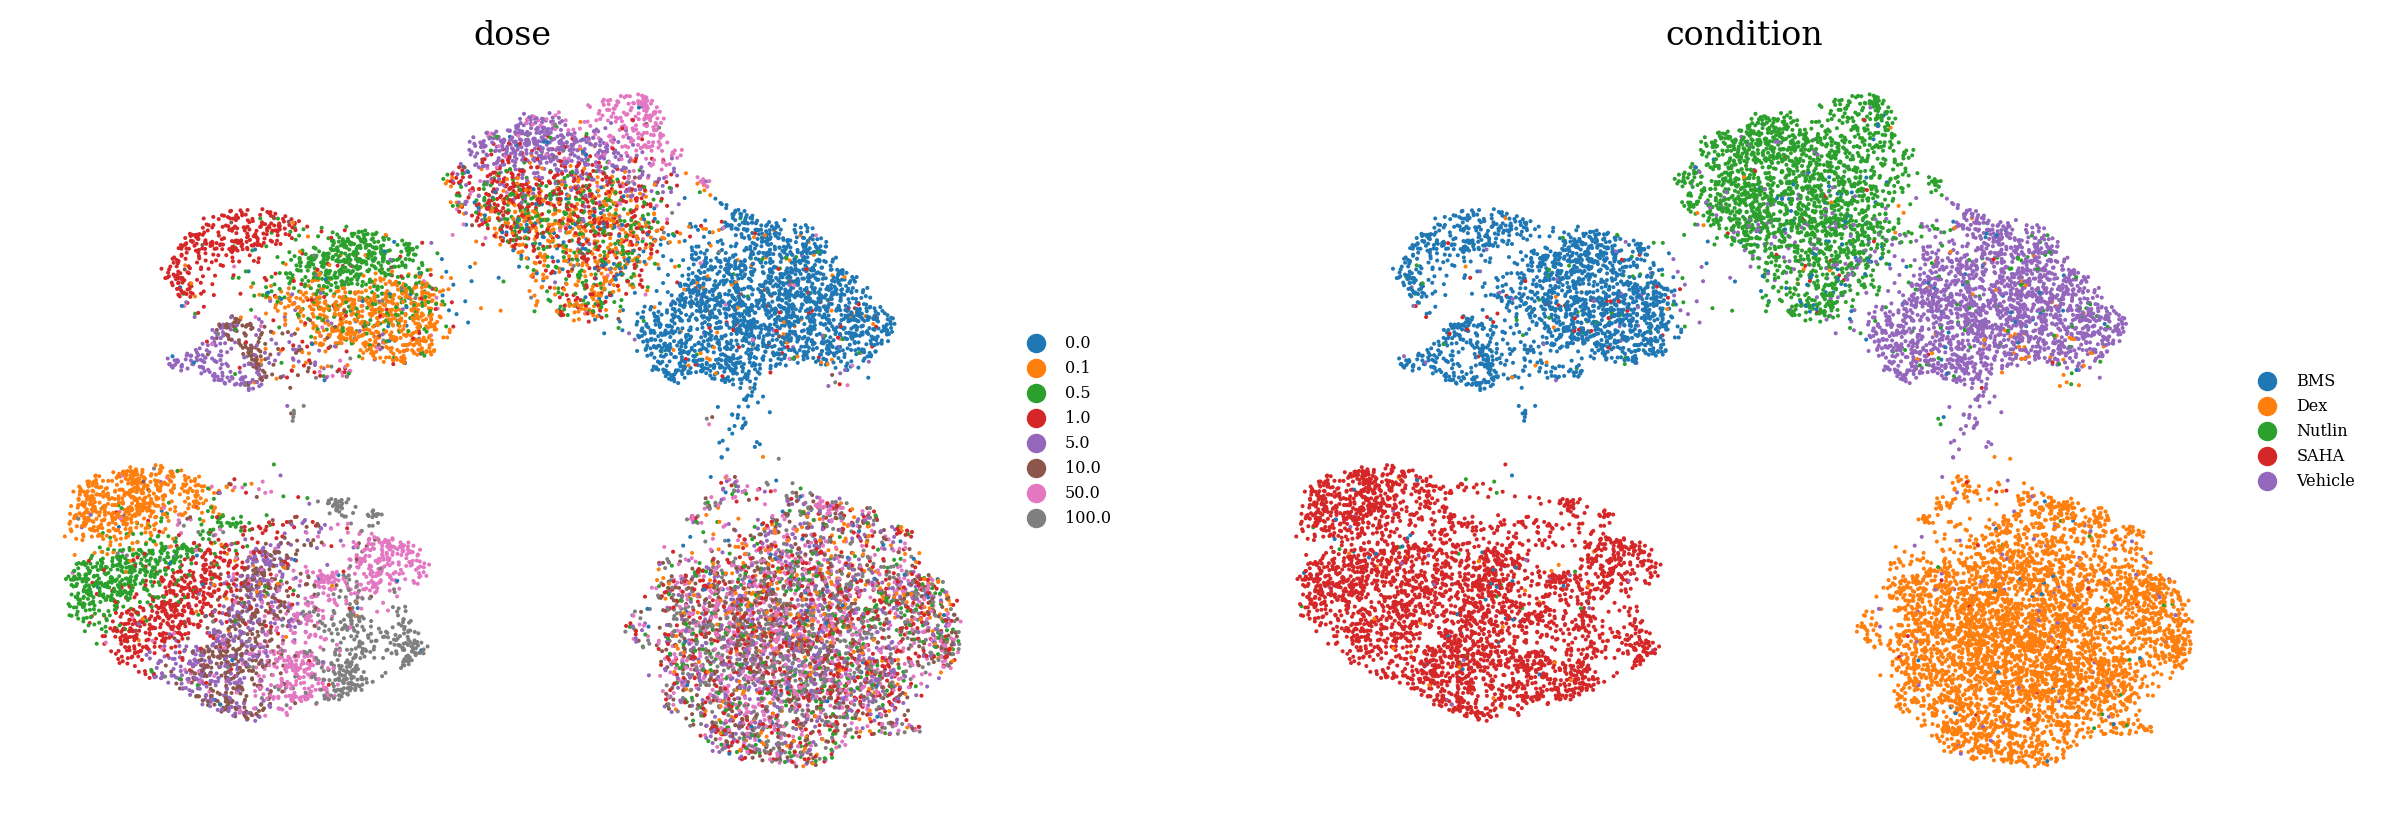

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

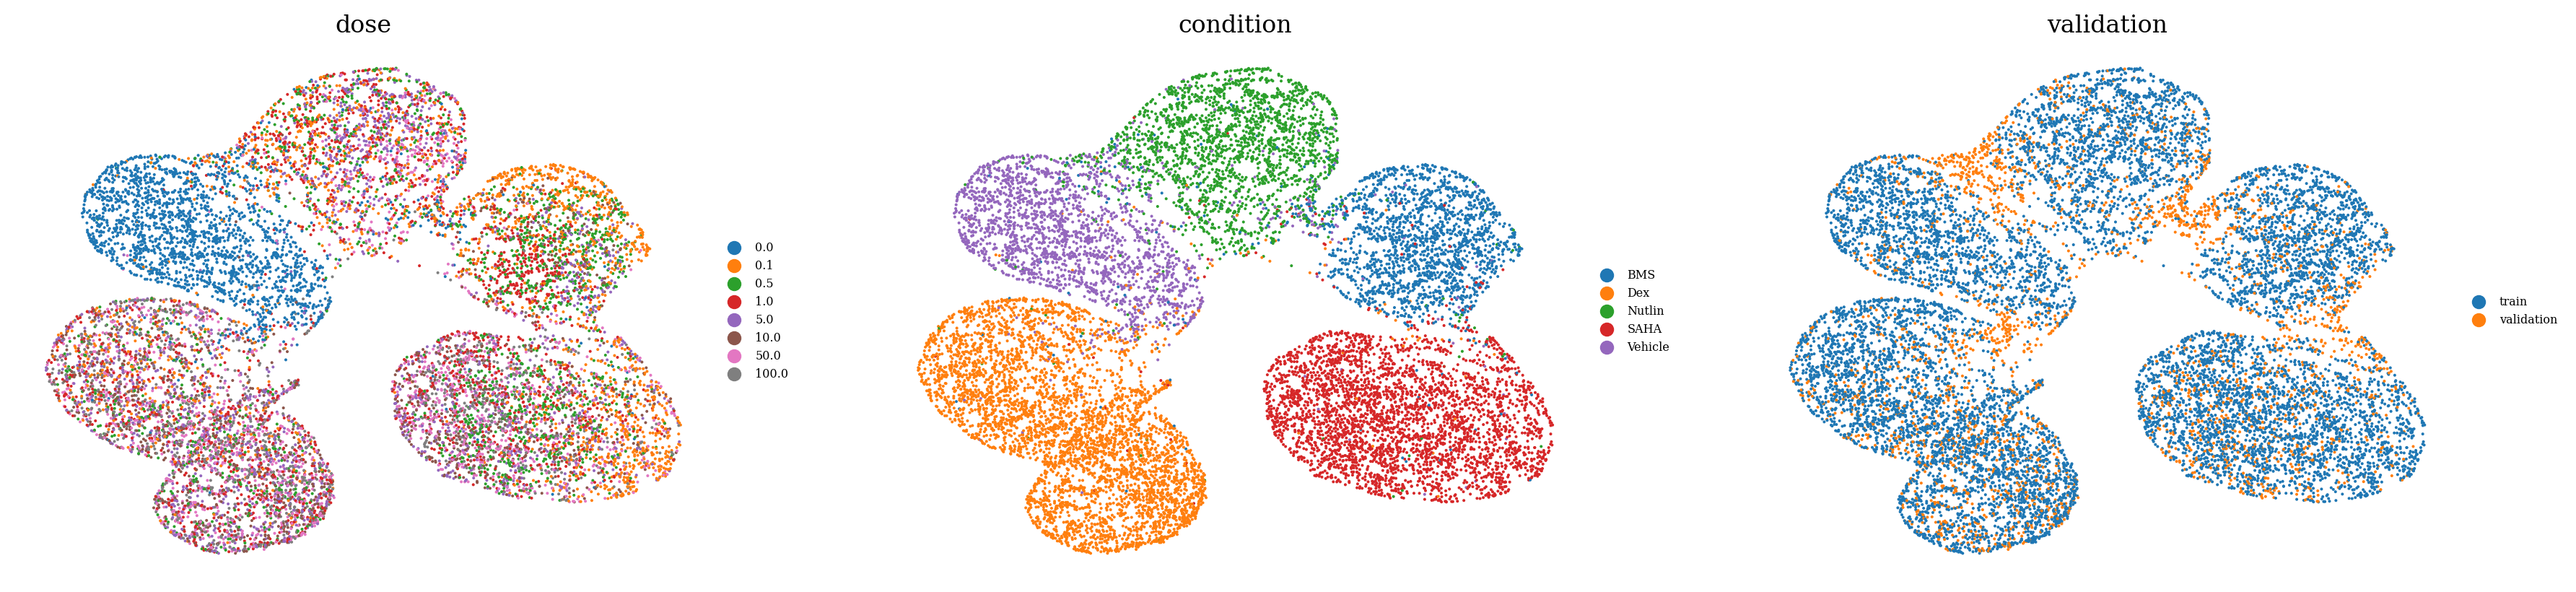

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


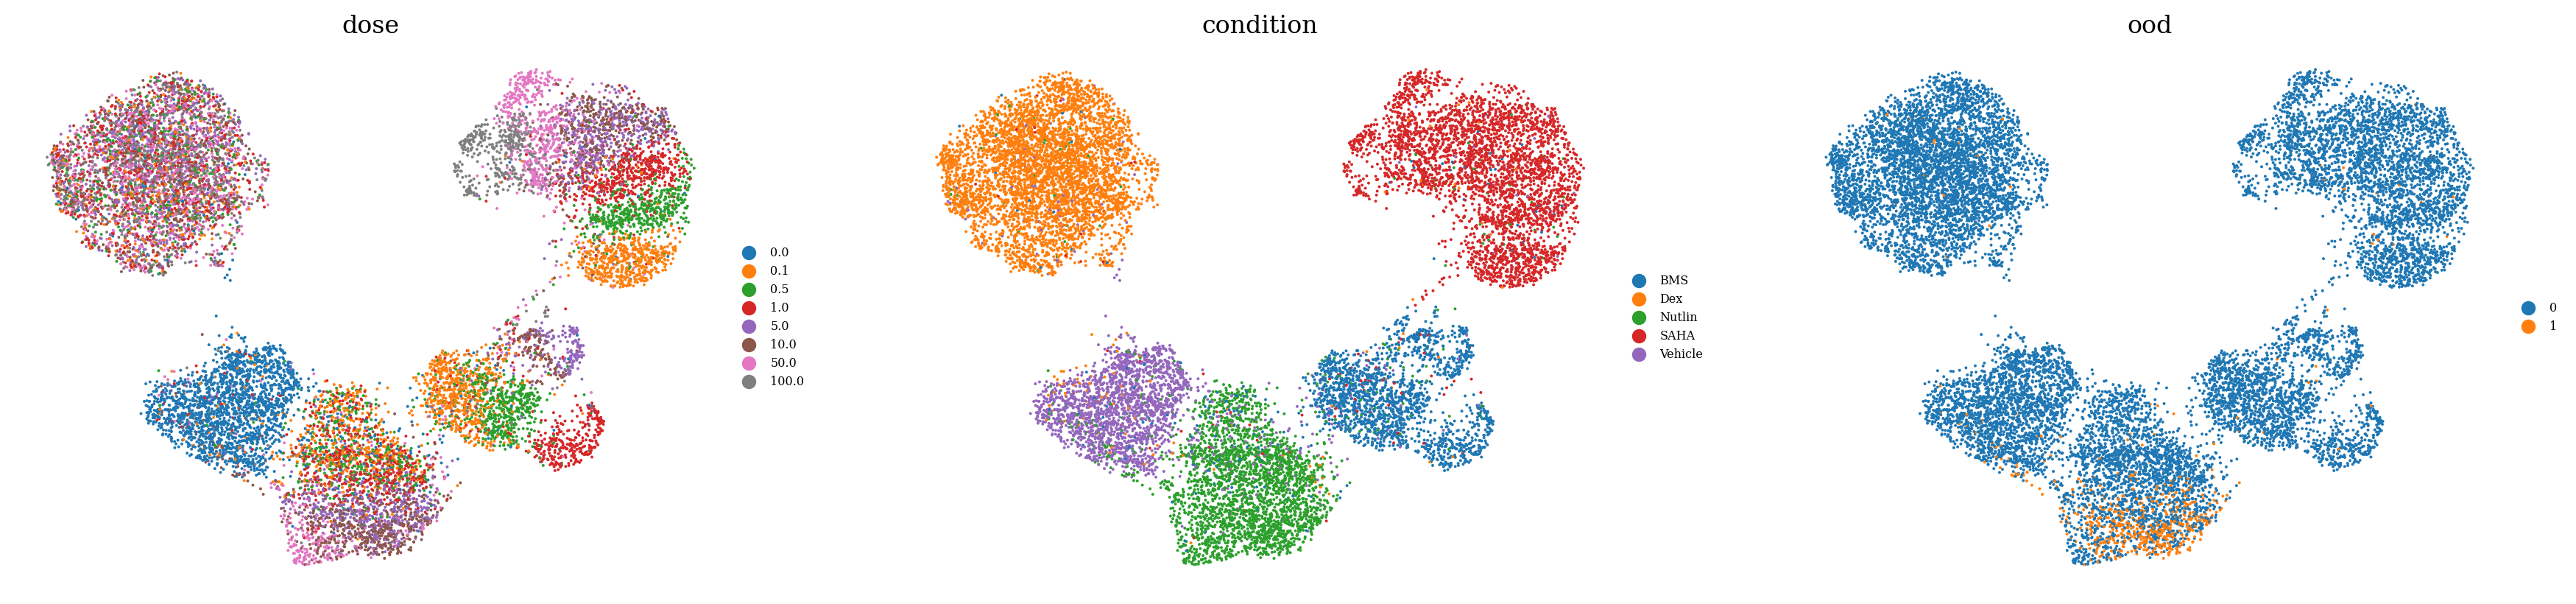

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


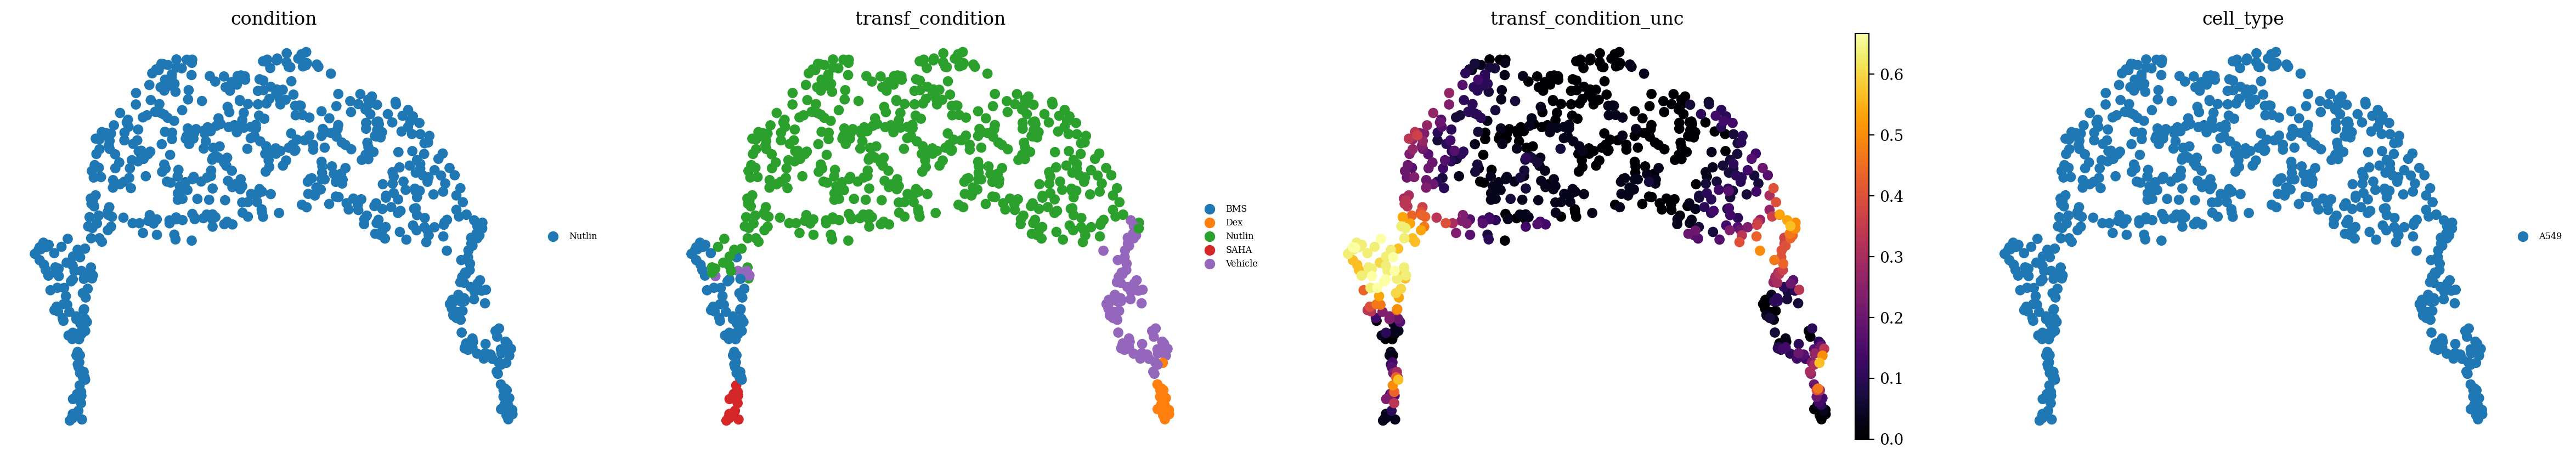

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.7442922374429224,
 'precision_macro': 0.2,
 'recall_macro': 0.14885844748858448,
 'f1_score_macro': 0.1706806282722513,
 'precision_micro': 0.7442922374429224,
 'recall_micro': 0.7442922374429224,
 'f1_score_micro': 0.7442922374429224,
 'precision_weighted': 1.0,
 'recall_weighted': 0.7442922374429224,
 'f1_score_weighted': 0.8534031413612565,
 'confusion_matrix': array([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [ 57,  18, 489,  16,  77],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.3016676794274526


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.2196340557693606
